In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys
import heapq
from functools import partial
from sklearn.model_selection import ParameterSampler
import glob, os
import time 

In [3]:
#ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings = pd.read_csv('ml-1m-2/ratings.dat', sep="::", engine="python", names=['userId', 'movieId', 'rating', 'timestamp'])

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

userId  movieId  rating           timestamp
0       1     1193       5 2000-12-31 22:12:40
1       1      661       3 2000-12-31 22:35:09
2       1      914       3 2000-12-31 22:32:48
3       1     3408       4 2000-12-31 22:04:35
4       1     2355       5 2001-01-06 23:38:11

In [82]:
summary_ = pd.read_csv('svd_val_test_summary4.csv')
summary_

month  n_factors  n_epochs   lr_all  reg_all  val_precision@10  val_rmse  \
0       2        256        50  0.01000  0.05000          0.814499  1.068274   
1       3         32        40  0.00100  0.01000          0.805706  1.016799   
2       4         64       100  0.00500  0.10000          0.817895  0.977997   
3       5        256        50  0.01000  0.05000          0.811350  0.990559   
4       6        256        50  0.01000  0.05000          0.794544  0.968904   
5       7         64       100  0.00500  0.10000          0.786281  0.950490   
6       8         32       100  0.00100  0.00100          0.817566  1.000631   
7       9         32       100  0.00100  0.00100          0.790186  0.962503   
8      10        128        50  0.00500  0.05000          0.698389  0.857611   
9      11        128        50  0.00500  0.05000          0.657874  0.876914   
10     12        256        30  0.01000  0.05000          0.711298  0.833410   
11     13        128        50  0.00500  0.05000          0.670294  0.886368   
12     14         64        40  0.00500  0.00001          0.636782  0.959579   
13     15        128        50  0.00500  0.05000          0.682345  0.848415   
14     16        256        30  0.01000  0.05000          0.678065  0.837275   
15     17        128        50  0.00500  0.05000          0.644962  0.910805   
16     18        256        30  0.01000  0.05000          0.716708  0.840002   
17     19        128        50  0.00500  0.05000          0.656030  0.879938   
18     20         32       100  0.00100  0.05000          0.661429  0.891892   
19     21        128        50  0.00500  0.05000          0.735072  0.851127   
20     22        128        50  0.00500  0.05000          0.667826  0.826432   
21     23        128        60  0.00100  0.05000          0.599960  0.858701   
22     24        128        50  0.00500  0.05000          0.624988  0.930436   
23     25         64        30  0.00500  0.00100          0.670228  0.981539   
24     26         32       100  0.00100  0.05000          0.591883  0.879301   
25     27          8        30  0.00001  0.00001          0.615924  1.054859   
26     28         32        50  0.00100  0.05000          0.632178  0.934739   
27     29         32        50  0.00100  0.05000          0.600000  0.933306   
28     30         32        50  0.00001  0.00001          0.634758  1.004607   
29     31         16        60  0.01000  0.00100          0.642326  0.852432   
30     32         64        60  0.00500  0.01000          0.661501  0.946014   
31     33         32       100  0.00100  0.00100          0.692737  0.925442   
32     34        256        50  0.01000  0.05000          0.644569  0.994158   

    test_precision@10  test_recall@10  test_rmse  
0            0.802240        0.292277   0.998456  
1            0.813133        0.283878   0.995398  
2            0.809974        0.257900   0.988975  
3            0.796449        0.364965   0.968092  
4            0.781141        0.409690   0.951564  
5            0.814858        0.272548   0.994027  
6            0.787986        0.367436   0.963021  
7            0.685735        0.536283   0.888122  
8            0.638307        0.537721   0.875734  
9            0.705460        0.598115   0.834150  
10           0.657372        0.595439   0.891492  
11           0.625972        0.569053   0.861823  
12           0.624637        0.553909   0.946734  
13           0.678060        0.598280   0.838866  
14           0.634916        0.555730   0.913394  
15           0.710604        0.646656   0.841591  
16           0.630476        0.570127   0.875552  
17           0.654275        0.547852   0.891597  
18           0.717095        0.613831   0.862710  
19           0.642320        0.568074   0.827531  
20           0.584012        0.497681   0.841862  
21           0.580293        0.554711   0.973718  
22           0.645351        0.561070   0.891438  
23           0.560459        0.489451   0.934559  
24      

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     1000209 non-null  int64         
 1   movieId    1000209 non-null  int64         
 2   rating     1000209 non-null  int64         
 3   timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


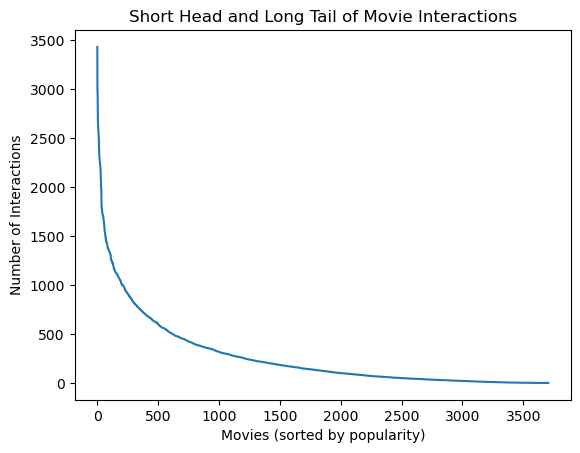

In [5]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


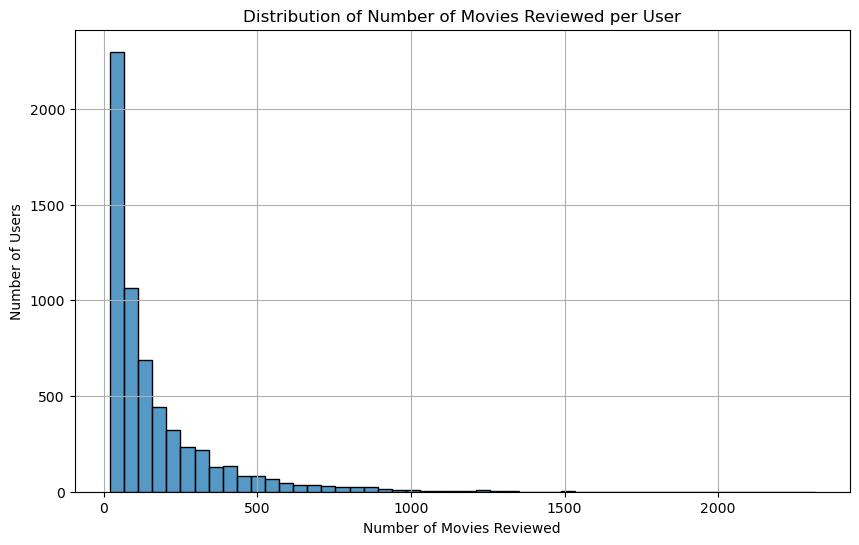

Number of users: 6040


In [6]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [7]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9553


## SVD++ Model

In [8]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
        recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_avg, recall_avg

In [9]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [10]:
def calculate_gini_of_recommendations(recommendation_counts):
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_counts.values()))

    # Calculate the Gini index
    gini_index = gini(recommendation_array)
    return gini_index

In [11]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [12]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [13]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_month(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [64]:

# Make month indices 
ratings = ratings.sort_values('timestamp').copy()
ratings['ym'] = ratings['timestamp'].dt.to_period('M')
unique_periods = np.sort(ratings['ym'].unique())
period_to_idx = {p: i+1 for i, p in enumerate(unique_periods)}
ratings['month_idx'] = ratings['ym'].map(period_to_idx)
M = int(ratings['month_idx'].max())
"""
# Random search space ---
param_distributions = {
    'n_factors': [8, 16, 32, 64, 128, 256],
    'n_epochs':  [30, 40, 50, 60, 80, 100],
    'lr_all':    [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0.1, 1.0],
    'reg_all':   [1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1],
}
n_iter = 60
random_state = None 

if random_state is None:
    # Generating a tracable seed
    chosen_seed = int(time.time()) % (2**32 - 1)
else:
    chosen_seed = random_state

print(f"[INFO] Using random_state = {chosen_seed}")

rng = np.random.RandomState(random_state)
sampled = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=rng))

# Force-in extremes
extreme_min = {'n_factors': 8,   'n_epochs': 30,  'lr_all': 1e-5, 'reg_all': 1e-5}
extreme_max = {'n_factors': 256, 'n_epochs': 100, 'lr_all': 1.0,  'reg_all': 0.1}
def _contains(lst, d): return any(all(x[k] == d[k] for k in d) for x in lst)
if not _contains(sampled, extreme_min): sampled.insert(0, extreme_min)
if not _contains(sampled, extreme_max): sampled.insert(1, extreme_max)


reader = Reader(rating_scale=(1, 5))
def to_surprise_trainset(df):
    data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    return data.build_full_trainset()
def to_surprise_testset(df):
    return list(zip(df['userId'].tolist(), df['movieId'].tolist(), df['rating'].tolist()))

# Rolling train (<= t-1), val (== t), test (== t+1) ---
rows = []
best_params_by_month = {}

for t in range(2, M):  # last usable is M-1
    train_df = ratings[ratings['month_idx'] <  t]
    val_df   = ratings[ratings['month_idx'] == t]
    test_df  = ratings[ratings['month_idx'] == t+1]
    if len(train_df)==0 or len(val_df)==0 or len(test_df)==0:
        continue

    trainset     = to_surprise_trainset(train_df)
    val_testset  = to_surprise_testset(val_df)
    test_testset = to_surprise_testset(test_df)

    # Validate: choose params by Precision@10 (tie-break lower RMSE) 
    cand_rows = []
    for params in sampled:
        model = SVD(**params, random_state=random_state)
        model.fit(trainset)
        val_preds = model.test(val_testset)
        val_rmse  = accuracy.rmse(val_preds, verbose=False)


        p_at_10, r_at_10 = precision_recall_at_k(val_preds, k=10, threshold=3.5)

        cand_rows.append({
            'month': t,
            **params,
            'val_precision@10': p_at_10,
            'val_recall@10': r_at_10,
            'val_rmse': val_rmse
        })

    cand_df = (pd.DataFrame(cand_rows)
               .sort_values(['val_precision@10','val_rmse'], ascending=[False, True])
               .reset_index(drop=True))
    best_params = {k: cand_df.loc[0, k] for k in ['n_factors','n_epochs','lr_all','reg_all']}
    best_params_by_month[t] = {
        'n_factors': int(best_params['n_factors']),
        'n_epochs' : int(best_params['n_epochs']),
        'lr_all'   : float(best_params['lr_all']),
        'reg_all'  : float(best_params['reg_all']),
    }

    #Refit on train+val, evaluate on test
    trainval_df = ratings[ratings['month_idx'] <= t]
    trainvalset = to_surprise_trainset(trainval_df)

    final_model = SVD(**best_params_by_month[t], random_state=random_state)
    final_model.fit(trainvalset)
    test_preds = final_model.test(test_testset)
    test_rmse  = accuracy.rmse(test_preds, verbose=False)

    # floats again
    test_p_at_10, test_r_at_10 = precision_recall_at_k(test_preds, k=10, threshold=3.5)

    rows.append({
        'month': t,
        **best_params_by_month[t],
        'val_precision@10': cand_df.loc[0, 'val_precision@10'],
        'val_rmse': cand_df.loc[0, 'val_rmse'],
        'test_precision@10': test_p_at_10,
        'test_recall@10': test_r_at_10,
        'test_rmse': test_rmse
    })

#Save chosen params 
valtest_summary = pd.DataFrame(rows).sort_values('month')
with open('svd_params_by_month_valselect4.json','w') as f:
    json.dump(best_params_by_month, f, indent=2)
valtest_summary.to_csv('svd_val_test_summary4.csv', index=False)

print("Saved:")
print(" - svd_params_by_month_valselect4.json (params chosen by validation Precision@10)")
print(" - svd_val_test_summary4.csv (validation & test metrics)")
display(valtest_summary.head())
"""

'\n# Random search space ---\nparam_distributions = {\n    \'n_factors\': [8, 16, 32, 64, 128, 256],\n    \'n_epochs\':  [30, 40, 50, 60, 80, 100],\n    \'lr_all\':    [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0.1, 1.0],\n    \'reg_all\':   [1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1],\n}\nn_iter = 60\nrandom_state = None \n\nif random_state is None:\n    # Generating a tracable seed\n    chosen_seed = int(time.time()) % (2**32 - 1)\nelse:\n    chosen_seed = random_state\n\nprint(f"[INFO] Using random_state = {chosen_seed}")\n\nrng = np.random.RandomState(random_state)\nsampled = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=rng))\n\n# Force-in extremes\nextreme_min = {\'n_factors\': 8,   \'n_epochs\': 30,  \'lr_all\': 1e-5, \'reg_all\': 1e-5}\nextreme_max = {\'n_factors\': 256, \'n_epochs\': 100, \'lr_all\': 1.0,  \'reg_all\': 0.1}\ndef _contains(lst, d): return any(all(x[k] == d[k] for k in d) for x in lst)\nif not _contains(sampled, extreme_min): sampled.insert(0, extreme_min)\

In [15]:
def evaluate_over_months(ratings, num_months, best_params_by_month=None):
    results = []
    recommendations = []
    train_test_sets = []
    original_recs = {}
    
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}

    long_tail_items = set(G[2])  

    start_date = ratings['timestamp'].min()

    for month_n in range(1, num_months + 1):
        end_date = start_date + pd.DateOffset(months=1)
        logging.info(f"Processing month {month_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_month(ratings, start_date, end_date)
        train_test_sets.append((trainset, testset, train_df, test_df))
        
        #Changed: pick per-month params if provided 
        params = {}
        if best_params_by_month is not None:
            params = best_params_by_month.get(month_n, best_params_by_month.get(str(month_n), {}))
        model = SVD(**params, random_state=42)
        # ----------------------------------------------------

        logging.info(f"Starting training for month {month_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for month {month_n}.")
        
        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)

        logging.info(f"month {month_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        candidate_items = set(train_df['movieId'].unique())
        user_rated_dict = train_df.groupby('userId')['movieId'].apply(set).to_dict()

        recs = {}
        logging.info(f"Generating recommendations for {len(active_users)} active users in month {month_n}...")
        
        for user_id in tqdm(active_users, desc=f"Recommending for month {month_n}"):
            rated_items = user_rated_dict.get(user_id, set())
            user_candidates = candidate_items - rated_items

            top_candidates = heapq.nlargest(100, user_candidates,
                                            key=lambda movie: model.predict(user_id, movie).est)

            user_recommendations = [(movie, model.predict(user_id, movie).est) for movie in top_candidates]
            top_ten = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:10]
            recs[user_id] = [movie for movie, rating in top_ten]

            recommendations.extend([(user_id, movie, rating, month_n) for movie, rating in user_recommendations])

        original_recs[month_n] = recs.copy()
        
        arp_value = arp_(active_users, recs, popularity)
        aplt_value = aplt(active_users, recs, long_tail_items)
        recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
        gini_index = calculate_gini_of_recommendations(recommendation_count)

        results.append({
            'month': month_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date

    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'month'])
    recommendations_df.to_csv("monthly_recommendations.csv", index=False)

    return results, recommendations_df, train_test_sets, original_recs



## Calibrated Popularity

In [16]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [17]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, month):
    print(f"Adding 'month' column for month {month}...")
    recs100['month'] = month  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'month' column is still there
    
    reranked['month'] = month  # Add the 'month' column manually here
    print("Checking reranked DataFrame after adding 'month':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [18]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [19]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
112
1069
2525
Calculating original user tolerance map...


In [20]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.26824432 0.57199277 0.15976291]
Standard deviation: [0.12167725 0.09051926 0.10418744]


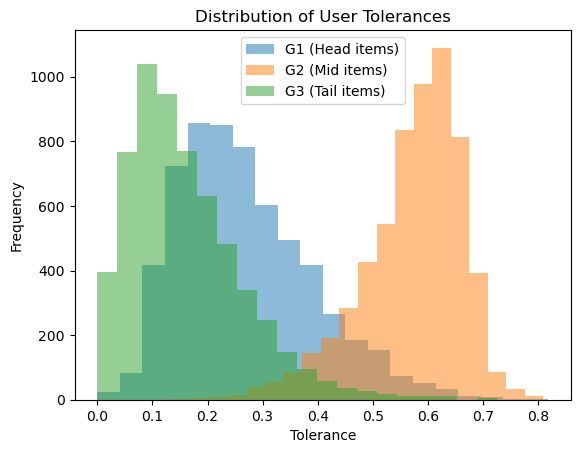

In [21]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("user_tolerances")
plt.show()

## Running the model

In [22]:
# ================= MAIN =================

#Load per-month optimal params chosen earlier via the train→val→test search
try:
    with open('svd_params_by_month_valselect4.json') as f:
        best_params_by_month = {int(k): v for k, v in json.load(f).items()}
    logging.info("Loaded per-month SVD params from svd_params_by_month_valselect.json")
except FileNotFoundError:
    best_params_by_month = None
    logging.warning("svd_params_by_month_valselect.json not found — using Surprise defaults.")

#Run monthly evaluation with those params
num_months = 32
monthly_results, recommendations_df, train_test_sets, original_recs = evaluate_over_months(
    ratings, 
    num_months, 
    best_params_by_month=best_params_by_month  
)

#Save the monthly results table
pd.DataFrame(monthly_results).to_csv("monthly_results_with_params4.csv", index=False)

# CP re-ranking 
all_reranked_recommendations = []
for month in range(1, num_months + 1):
    print(f"Processing month {month}...")
    monthly_recommendations = recommendations_df[recommendations_df['month'] == month]

    print(f"Checking monthly recommendations for month {month}:")
    print(monthly_recommendations.head())

    logging.info(f"Applying CP re-ranking for month {month}...")
    reranked_recommendations = cali(monthly_recommendations, alpha, k, month)
    all_reranked_recommendations.append(reranked_recommendations)

#Combine & save CP outputs
reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)
#print("Checking final reranked_df:")
#print(reranked_df.head())

#reranked_df.to_csv("monthly_reranked_recommendations.csv", index=False)

#print(pd.DataFrame(monthly_results))


2025-10-27 19:04:35,660 - Loaded per-month SVD params from svd_params_by_month_valselect.json
2025-10-27 19:04:35,668 - Processing month 1 (2000-04-25 to 2000-05-25)...
2025-10-27 19:04:35,739 - Starting training for month 1...
2025-10-27 19:04:35,996 - Training complete for month 1.
2025-10-27 19:04:36,025 - month 1 RMSE: 0.9969
2025-10-27 19:04:36,033 - Generating recommendations for 466 active users in month 1...
Recommending for month 1: 100%|██████████████| 466/466 [00:03<00:00, 154.25it/s]
2025-10-27 19:04:39,074 - Processing month 2 (2000-05-25 to 2000-06-25)...
2025-10-27 19:04:39,140 - Starting training for month 2...
2025-10-27 19:04:40,491 - Training complete for month 2.
2025-10-27 19:04:40,527 - month 2 RMSE: 0.9238
2025-10-27 19:04:40,537 - Generating recommendations for 515 active users in month 2...
Recommending for month 2: 100%|██████████████| 515/515 [00:03<00:00, 170.17it/s]
2025-10-27 19:04:43,574 - Processing month 3 (2000-06-25 to 2000-07-25)...
2025-10-27 19:04:

Recommending for month 20: 100%|█████████████| 174/174 [00:00<00:00, 385.41it/s]
2025-10-27 19:05:47,737 - Processing month 21 (2001-12-25 to 2002-01-25)...
2025-10-27 19:05:47,748 - Starting training for month 21...
2025-10-27 19:05:47,795 - Training complete for month 21.
2025-10-27 19:05:47,811 - month 21 RMSE: 0.9939
2025-10-27 19:05:47,814 - Generating recommendations for 228 active users in month 21...
Recommending for month 21: 100%|█████████████| 228/228 [00:00<00:00, 331.34it/s]
2025-10-27 19:05:48,506 - Processing month 22 (2002-01-25 to 2002-02-25)...
2025-10-27 19:05:48,516 - Starting training for month 22...
2025-10-27 19:05:48,553 - Training complete for month 22.
2025-10-27 19:05:48,565 - month 22 RMSE: 0.9923
2025-10-27 19:05:48,568 - Generating recommendations for 196 active users in month 22...
Recommending for month 22: 100%|█████████████| 196/196 [00:00<00:00, 376.19it/s]
2025-10-27 19:05:49,093 - Processing month 23 (2002-02-25 to 2002-03-25)...
2025-10-27 19:05:49

Processing month 1...
Checking monthly recommendations for month 1:
   userId  movieId    rating  month
0    5574      858  5.000000      1
1    5574     1221  4.885696      1
2    5574     2019  4.880351      1
3    5574      318  4.861907      1
4    5574     1199  4.860772      1
Adding 'month' column for month 1...
Checking recs100 before reranking:
   userId  movieId    rating  month
0    5574      858  5.000000      1
1    5574     1221  4.885696      1
2    5574     2019  4.880351      1
3    5574      318  4.861907      1
4    5574     1199  4.860772      1
####### Starting the reranking...


 24%|██████████                               | 114/466 [00:05<00:15, 22.45it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 466/466 [00:21<00:00, 21.98it/s]
2025-10-27 19:06:17,653 - Applying CP re-ranking for month 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5574      858  5.000000
1    5574     1221  4.885696
2    5574     2019  4.880351
3    5574     2186  4.770152
4    5574     1199  4.860772
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5574      858  5.000000      1
1    5574     1221  4.885696      1
2    5574     2019  4.880351      1
3    5574     2186  4.770152      1
4    5574     1199  4.860772      1
Processing month 2...
Checking monthly recommendations for month 2:
       userId  movieId    rating  month
46600    5152      260  4.489573      2
46601    5152     1252  4.426840      2
46602    5152     1224  4.414775      2
46603    5152     2019  4.339535      2
46604    5152      593  4.312023      2
Adding 'month' column for month 2...
Checking recs100 before reranking:
       userId  movieId    rating  month
46600    5152      260  4.489573      2
46601    5152     1252  4.426840      2
46602    5152     1224  4.41477

100%|█████████████████████████████████████████| 515/515 [00:23<00:00, 22.01it/s]
2025-10-27 19:06:41,074 - Applying CP re-ranking for month 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5152      260  4.489573
1    5152     1252  4.426840
2    5152     1224  4.414775
3    5152     2019  4.339535
4    5152      593  4.312023
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5152      260  4.489573      2
1    5152     1252  4.426840      2
2    5152     1224  4.414775      2
3    5152     2019  4.339535      2
4    5152      593  4.312023      2
Processing month 3...
Checking monthly recommendations for month 3:
       userId  movieId    rating  month
98100    4551     1148  4.765505      3
98101    4551      745  4.679699      3
98102    4551     1207  4.660154      3
98103    4551     2019  4.630931      3
98104    4551      953  4.623805      3
Adding 'month' column for month 3...
Checking recs100 before reranking:
       userId  movieId    rating  month
98100    4551     1148  4.765505      3
98101    4551      745  4.679699      3
98102    4551     1207  4.66015

 41%|████████████████▊                        | 300/733 [00:13<00:19, 22.11it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 733/733 [00:33<00:00, 21.96it/s]
2025-10-27 19:07:14,490 - Applying CP re-ranking for month 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4551     1148  4.765505
1    4551      745  4.679699
2    4551     1207  4.660154
3    4551     2019  4.630931
4    4551      953  4.623805
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4551     1148  4.765505      3
1    4551      745  4.679699      3
2    4551     1207  4.660154      3
3    4551     2019  4.630931      3
4    4551      953  4.623805      3
Processing month 4...
Checking monthly recommendations for month 4:
        userId  movieId    rating  month
171400    3450     3338  4.622779      4
171401    3450     2931  4.596579      4
171402    3450     3306  4.521584      4
171403    3450     2494  4.483102      4
171404    3450      858  4.476711      4
Adding 'month' column for month 4...
Checking recs100 before reranking:
        userId  movieId    rating  month
171400    3450     3338  4.622779      4
171401    3450     2931  4.596579      4
171402    3450     330

 63%|█████████████████████████               | 804/1284 [00:36<00:22, 21.70it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 1284/1284 [00:58<00:00, 21.87it/s]
2025-10-27 19:08:13,246 - Applying CP re-ranking for month 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3450     3338  4.622779
1    3450     2931  4.596579
2    3450     1242  4.300862
3    3450      678  4.336921
4    3450      858  4.476711
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3450     3338  4.622779      4
1    3450     2931  4.596579      4
2    3450     1242  4.300862      4
3    3450      678  4.336921      4
4    3450      858  4.476711      4
Processing month 5...
Checking monthly recommendations for month 5:
        userId  movieId    rating  month
299800    3075     1222  4.477793      5
299801    3075     1223  4.352134      5
299802    3075     2937  4.347798      5
299803    3075     1250  4.329297      5
299804    3075      905  4.309761      5
Adding 'month' column for month 5...
Checking recs100 before reranking:
        userId  movieId    rating  month
299800    3075     1222  4.477793      5
299801    3075     1223  4.352134      5
299802    3075     293

100%|█████████████████████████████████████████| 650/650 [00:29<00:00, 21.95it/s]
2025-10-27 19:08:42,883 - Applying CP re-ranking for month 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3075     1222  4.477793
1    3075     1223  4.352134
2    3075     2937  4.347798
3    3075     1250  4.329297
4    3075     1225  4.226430
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3075     1222  4.477793      5
1    3075     1223  4.352134      5
2    3075     2937  4.347798      5
3    3075     1250  4.329297      5
4    3075     1225  4.226430      5
Processing month 6...
Checking monthly recommendations for month 6:
        userId  movieId    rating  month
364800    2848     2762  4.458399      6
364801    2848     1212  4.396131      6
364802    2848     1175  4.351908      6
364803    2848     1218  4.339842      6
364804    2848     3030  4.338585      6
Adding 'month' column for month 6...
Checking recs100 before reranking:
        userId  movieId    rating  month
364800    2848     2762  4.458399      6
364801    2848     1212  4.396131      6
364802    2848     117

100%|█████████████████████████████████████████| 482/482 [00:21<00:00, 21.96it/s]
2025-10-27 19:09:04,859 - Applying CP re-ranking for month 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2848     2762  4.458399
1    2848     1212  4.396131
2    2848     3911  4.195910
3    2848     1218  4.339842
4    2848     3911  4.195910
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2848     2762  4.458399      6
1    2848     1212  4.396131      6
2    2848     3911  4.195910      6
3    2848     1218  4.339842      6
4    2848     3911  4.195910      6
Processing month 7...
Checking monthly recommendations for month 7:
        userId  movieId    rating  month
413000     928     2019  4.822833      7
413001     928     1178  4.818969      7
413002     928     2843  4.804780      7
413003     928     2925  4.803184      7
413004     928     1237  4.797791      7
Adding 'month' column for month 7...
Checking recs100 before reranking:
        userId  movieId    rating  month
413000     928     2019  4.822833      7
413001     928     1178  4.818969      7
413002     928     284

  5%|██▏                                     | 114/2141 [00:05<01:29, 22.63it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 2141/2141 [01:35<00:00, 22.33it/s]
2025-10-27 19:10:40,831 - Applying CP re-ranking for month 8...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     928     2019  4.822833
1     928     1178  4.818969
2     928     2843  4.804780
3     928      750  4.768561
4     928     1237  4.797791
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     928     2019  4.822833      7
1     928     1178  4.818969      7
2     928     2843  4.804780      7
3     928      750  4.768561      7
4     928     1237  4.797791      7
Processing month 8...
Checking monthly recommendations for month 8:
        userId  movieId    rating  month
627100      81      318  5.000000      8
627101      81      858  4.996849      8
627102      81      608  4.984083      8
627103      81      593  4.940011      8
627104      81     1148  4.937863      8
Adding 'month' column for month 8...
Checking recs100 before reranking:
        userId  movieId    rating  month
627100      81      318  5.000000      8
627101      81      858  4.996849      8
627102      81      60

 33%|█████████████▎                          | 477/1436 [00:21<00:44, 21.38it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 1436/1436 [01:05<00:00, 21.99it/s]
2025-10-27 19:11:46,185 - Applying CP re-ranking for month 9...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      81      318  5.000000
1      81      858  4.996849
2      81     1147  4.888898
3      81     3030  4.841492
4      81     1148  4.937863
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      81      318  5.000000      8
1      81      858  4.996849      8
2      81     1147  4.888898      8
3      81     3030  4.841492      8
4      81     1148  4.937863      8
Processing month 9...
Checking monthly recommendations for month 9:
        userId  movieId    rating  month
770700       1     1198  4.835521      9
770701       1     1234  4.814817      9
770702       1      318  4.800921      9
770703       1      356  4.746183      9
770704       1      858  4.715388      9
Adding 'month' column for month 9...
Checking recs100 before reranking:
        userId  movieId    rating  month
770700       1     1198  4.835521      9
770701       1     1234  4.814817      9
770702       1      31

100%|█████████████████████████████████████████| 633/633 [00:28<00:00, 22.01it/s]
2025-10-27 19:12:14,972 - Applying CP re-ranking for month 10...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0       1     1198  4.835521
1       1     1234  4.814817
2       1      318  4.800921
3       1      356  4.746183
4       1      858  4.715388
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0       1     1198  4.835521      9
1       1     1234  4.814817      9
2       1      318  4.800921      9
3       1      356  4.746183      9
4       1      858  4.715388      9
Processing month 10...
Checking monthly recommendations for month 10:
        userId  movieId    rating  month
834000      10      858  4.787726     10
834001      10       50  4.718879     10
834002      10       34  4.714494     10
834003      10     3095  4.708054     10
834004      10      337  4.672289     10
Adding 'month' column for month 10...
Checking recs100 before reranking:
        userId  movieId    rating  month
834000      10      858  4.787726     10
834001      10       50  4.718879     10
834002      10     

100%|█████████████████████████████████████████| 429/429 [00:19<00:00, 22.00it/s]
2025-10-27 19:12:34,490 - Applying CP re-ranking for month 11...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      10      858  4.787726
1      10       50  4.718879
2      10     2112  4.571266
3      10     3095  4.708054
4      10      337  4.672289
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      10      858  4.787726     10
1      10       50  4.718879     10
2      10     2112  4.571266     10
3      10     3095  4.708054     10
4      10      337  4.672289     10
Processing month 11...
Checking monthly recommendations for month 11:
        userId  movieId    rating  month
876900      36      904  4.806874     11
876901      36     1203  4.668797     11
876902      36     1148  4.627682     11
876903      36     1211  4.593049     11
876904      36     3730  4.582680     11
Adding 'month' column for month 11...
Checking recs100 before reranking:
        userId  movieId    rating  month
876900      36      904  4.806874     11
876901      36     1203  4.668797     11
876902      36     

100%|█████████████████████████████████████████| 315/315 [00:14<00:00, 22.29it/s]
2025-10-27 19:12:48,639 - Applying CP re-ranking for month 12...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36      904  4.806874
1      36     1203  4.668797
2      36     1148  4.627682
3      36     1211  4.593049
4      36     3730  4.582680
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36      904  4.806874     11
1      36     1203  4.668797     11
2      36     1148  4.627682     11
3      36     1211  4.593049     11
4      36     3730  4.582680     11
Processing month 12...
Checking monthly recommendations for month 12:
        userId  movieId    rating  month
908400      24      318  4.546331     12
908401      24     2804  4.525180     12
908402      24     1302  4.508972     12
908403      24     2413  4.503974     12
908404      24      593  4.498612     12
Adding 'month' column for month 12...
Checking recs100 before reranking:
        userId  movieId    rating  month
908400      24      318  4.546331     12
908401      24     2804  4.525180     12
908402      24     

100%|█████████████████████████████████████████| 307/307 [00:13<00:00, 22.21it/s]
2025-10-27 19:13:02,477 - Applying CP re-ranking for month 13...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      24      318  4.546331
1      24     2804  4.525180
2      24     1302  4.508972
3      24     2413  4.503974
4      24      593  4.498612
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      24      318  4.546331     12
1      24     2804  4.525180     12
2      24     1302  4.508972     12
3      24     2413  4.503974     12
4      24      593  4.498612     12
Processing month 13...
Checking monthly recommendations for month 13:
        userId  movieId    rating  month
939100      65      590  4.546054     13
939101      65     2804  4.426114     13
939102      65     3897  4.425346     13
939103      65      953  4.405850     13
939104      65      318  4.350714     13
Adding 'month' column for month 13...
Checking recs100 before reranking:
        userId  movieId    rating  month
939100      65      590  4.546054     13
939101      65     2804  4.426114     13
939102      65     

100%|█████████████████████████████████████████| 254/254 [00:11<00:00, 22.45it/s]
2025-10-27 19:13:13,803 - Applying CP re-ranking for month 14...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65      590  4.546054
1      65     2804  4.426114
2      65     3897  4.425346
3      65      953  4.405850
4      65      318  4.350714
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65      590  4.546054     13
1      65     2804  4.426114     13
2      65     3897  4.425346     13
3      65      953  4.405850     13
4      65      318  4.350714     13
Processing month 14...
Checking monthly recommendations for month 14:
        userId  movieId    rating  month
964500      22     2028  4.510329     14
964501      22      858  4.506086     14
964502      22     3897  4.396928     14
964503      22      913  4.374940     14
964504      22     2396  4.355727     14
Adding 'month' column for month 14...
Checking recs100 before reranking:
        userId  movieId    rating  month
964500      22     2028  4.510329     14
964501      22      858  4.506086     14
964502      22     

100%|█████████████████████████████████████████| 294/294 [00:13<00:00, 22.48it/s]
2025-10-27 19:13:26,902 - Applying CP re-ranking for month 15...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      22     2028  4.510329
1      22      858  4.506086
2      22     3897  4.396928
3      22      913  4.374940
4      22      150  4.250289
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      22     2028  4.510329     14
1      22      858  4.506086     14
2      22     3897  4.396928     14
3      22      913  4.374940     14
4      22      150  4.250289     14
Processing month 15...
Checking monthly recommendations for month 15:
        userId  movieId    rating  month
993900      19      750  4.400132     15
993901      19     1954  4.351632     15
993902      19       50  4.343956     15
993903      19     1246  4.273882     15
993904      19      260  4.267488     15
Adding 'month' column for month 15...
Checking recs100 before reranking:
        userId  movieId    rating  month
993900      19      750  4.400132     15
993901      19     1954  4.351632     15
993902      19     

100%|█████████████████████████████████████████| 288/288 [00:12<00:00, 22.33it/s]
2025-10-27 19:13:39,817 - Applying CP re-ranking for month 16...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      19      750  4.400132
1      19     1954  4.351632
2      19       50  4.343956
3      19     1246  4.273882
4      19      260  4.267488
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      19      750  4.400132     15
1      19     1954  4.351632     15
2      19       50  4.343956     15
3      19     1246  4.273882     15
4      19      260  4.267488     15
Processing month 16...
Checking monthly recommendations for month 16:
         userId  movieId    rating  month
1022700     116      527  4.581620     16
1022701     116      260  4.514622     16
1022702     116     1845  4.508333     16
1022703     116      720  4.431451     16
1022704     116      858  4.403912     16
Adding 'month' column for month 16...
Checking recs100 before reranking:
         userId  movieId    rating  month
1022700     116      527  4.581620     16
1022701     116      260  4.514622     16
1022702   

100%|█████████████████████████████████████████| 259/259 [00:11<00:00, 22.51it/s]
2025-10-27 19:13:51,338 - Applying CP re-ranking for month 17...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     116      527  4.581620
1     116      260  4.514622
2     116     1845  4.508333
3     116      720  4.431451
4     116     1104  4.316172
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     116      527  4.581620     16
1     116      260  4.514622     16
2     116     1845  4.508333     16
3     116      720  4.431451     16
4     116     1104  4.316172     16
Processing month 17...
Checking monthly recommendations for month 17:
         userId  movieId    rating  month
1048600      65     1204  4.221245     17
1048601      65     2028  4.205323     17
1048602      65     2959  4.204940     17
1048603      65      593  4.196870     17
1048604      65     1207  4.163806     17
Adding 'month' column for month 17...
Checking recs100 before reranking:
         userId  movieId    rating  month
1048600      65     1204  4.221245     17
1048601      65     2028  4.205323     17
1048602   

100%|█████████████████████████████████████████| 204/204 [00:09<00:00, 22.59it/s]
2025-10-27 19:14:00,382 - Applying CP re-ranking for month 18...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     1204  4.221245
1      65     2028  4.205323
2      65     2959  4.204940
3      65      593  4.196870
4      65     1207  4.163806
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     1204  4.221245     17
1      65     2028  4.205323     17
2      65     2959  4.204940     17
3      65      593  4.196870     17
4      65     1207  4.163806     17
Processing month 18...
Checking monthly recommendations for month 18:
         userId  movieId    rating  month
1069000     102     1704  3.982539     18
1069001     102     2437  3.834752     18
1069002     102     1249  3.818021     18
1069003     102     1179  3.794772     18
1069004     102     1953  3.774515     18
Adding 'month' column for month 18...
Checking recs100 before reranking:
         userId  movieId    rating  month
1069000     102     1704  3.982539     18
1069001     102     2437  3.834752     18
1069002   

100%|█████████████████████████████████████████| 175/175 [00:07<00:00, 22.62it/s]
2025-10-27 19:14:08,132 - Applying CP re-ranking for month 19...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     102     1704  3.982539
1     102     2437  3.834752
2     102     1249  3.818021
3     102     1179  3.794772
4     102     1953  3.774515
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     102     1704  3.982539     18
1     102     2437  3.834752     18
2     102     1249  3.818021     18
3     102     1179  3.794772     18
4     102     1953  3.774515     18
Processing month 19...
Checking monthly recommendations for month 19:
         userId  movieId    rating  month
1086500      44      923  4.352757     19
1086501      44      858  4.231338     19
1086502      44     2762  4.221493     19
1086503      44       50  4.154469     19
1086504      44      527  4.089844     19
Adding 'month' column for month 19...
Checking recs100 before reranking:
         userId  movieId    rating  month
1086500      44      923  4.352757     19
1086501      44      858  4.231338     19
1086502   

100%|█████████████████████████████████████████| 190/190 [00:08<00:00, 22.66it/s]
2025-10-27 19:14:16,531 - Applying CP re-ranking for month 20...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      44      923  4.352757
1      44      858  4.231338
2      44     2762  4.221493
3      44       50  4.154469
4      44     2693  3.801705
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      44      923  4.352757     19
1      44      858  4.231338     19
2      44     2762  4.221493     19
3      44       50  4.154469     19
4      44     2693  3.801705     19
Processing month 20...
Checking monthly recommendations for month 20:
         userId  movieId    rating  month
1105500     127     2571  4.004713     20
1105501     127     1210  3.988122     20
1105502     127     3114  3.949022     20
1105503     127     1240  3.942091     20
1105504     127     1221  3.904283     20
Adding 'month' column for month 20...
Checking recs100 before reranking:
         userId  movieId    rating  month
1105500     127     2571  4.004713     20
1105501     127     1210  3.988122     20
1105502   

100%|█████████████████████████████████████████| 174/174 [00:07<00:00, 22.66it/s]
2025-10-27 19:14:24,219 - Applying CP re-ranking for month 21...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     127     2571  4.004713
1     127     1210  3.988122
2     127     3114  3.949022
3     127     1178  3.740253
4     127      923  3.809930
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     127     2571  4.004713     20
1     127     1210  3.988122     20
2     127     3114  3.949022     20
3     127     1178  3.740253     20
4     127      923  3.809930     20
Processing month 21...
Checking monthly recommendations for month 21:
         userId  movieId    rating  month
1122900      20     1276  4.473844     21
1122901      20     1198  4.432816     21
1122902      20      111  4.416773     21
1122903      20      926  4.409150     21
1122904      20     2919  4.381850     21
Adding 'month' column for month 21...
Checking recs100 before reranking:
         userId  movieId    rating  month
1122900      20     1276  4.473844     21
1122901      20     1198  4.432816     21
1122902   

100%|█████████████████████████████████████████| 228/228 [00:10<00:00, 22.52it/s]
2025-10-27 19:14:34,357 - Applying CP re-ranking for month 22...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      20     1276  4.473844
1      20     1198  4.432816
2      20      111  4.416773
3      20      926  4.409150
4      20     2919  4.381850
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      20     1276  4.473844     21
1      20     1198  4.432816     21
2      20      111  4.416773     21
3      20      926  4.409150     21
4      20     2919  4.381850     21
Processing month 22...
Checking monthly recommendations for month 22:
         userId  movieId    rating  month
1145700      36      527  4.681067     22
1145701      36     3471  4.551483     22
1145702      36     1288  4.551333     22
1145703      36      858  4.521550     22
1145704      36     1653  4.516584     22
Adding 'month' column for month 22...
Checking recs100 before reranking:
         userId  movieId    rating  month
1145700      36      527  4.681067     22
1145701      36     3471  4.551483     22
1145702   

100%|█████████████████████████████████████████| 196/196 [00:08<00:00, 22.62it/s]
2025-10-27 19:14:43,034 - Applying CP re-ranking for month 23...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36      527  4.681067
1      36     3471  4.551483
2      36     1288  4.551333
3      36     1952  4.454878
4      36     1653  4.516584
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36      527  4.681067     22
1      36     3471  4.551483     22
2      36     1288  4.551333     22
3      36     1952  4.454878     22
4      36     1653  4.516584     22
Processing month 23...
Checking monthly recommendations for month 23:
         userId  movieId    rating  month
1165300      36     1517  4.403453     23
1165301      36     3147  4.348158     23
1165302      36     2300  4.315803     23
1165303      36     3198  4.286348     23
1165304      36     3624  4.255497     23
Adding 'month' column for month 23...
Checking recs100 before reranking:
         userId  movieId    rating  month
1165300      36     1517  4.403453     23
1165301      36     3147  4.348158     23
1165302   

100%|█████████████████████████████████████████| 160/160 [00:08<00:00, 18.36it/s]
2025-10-27 19:14:51,762 - Applying CP re-ranking for month 24...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36     1517  4.403453
1      36     3147  4.348158
2      36     2300  4.315803
3      36     3198  4.286348
4      36     3624  4.255497
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36     1517  4.403453     23
1      36     3147  4.348158     23
2      36     2300  4.315803     23
3      36     3198  4.286348     23
4      36     3624  4.255497     23
Processing month 24...
Checking monthly recommendations for month 24:
         userId  movieId    rating  month
1181300      65     2677  4.386017     24
1181301      65     3598  4.379126     24
1181302      65     1254  4.275401     24
1181303      65     3271  4.268533     24
1181304      65     3911  4.262454     24
Adding 'month' column for month 24...
Checking recs100 before reranking:
         userId  movieId    rating  month
1181300      65     2677  4.386017     24
1181301      65     3598  4.379126     24
1181302   

100%|█████████████████████████████████████████| 146/146 [00:06<00:00, 21.60it/s]
2025-10-27 19:14:58,532 - Applying CP re-ranking for month 25...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     2677  4.386017
1      65     3897  4.168896
2      65     1254  4.275401
3      65     3271  4.268533
4      65     3911  4.262454
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     2677  4.386017     24
1      65     3897  4.168896     24
2      65     1254  4.275401     24
3      65     3271  4.268533     24
4      65     3911  4.262454     24
Processing month 25...
Checking monthly recommendations for month 25:
         userId  movieId    rating  month
1195900     134       50  4.402477     25
1195901     134      232  4.316495     25
1195902     134     3361  4.225941     25
1195903     134     2248  4.225627     25
1195904     134      508  4.219393     25
Adding 'month' column for month 25...
Checking recs100 before reranking:
         userId  movieId    rating  month
1195900     134       50  4.402477     25
1195901     134      232  4.316495     25
1195902   

100%|█████████████████████████████████████████| 151/151 [00:06<00:00, 22.57it/s]
2025-10-27 19:15:05,234 - Applying CP re-ranking for month 26...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     134       50  4.402477
1     134      232  4.316495
2     134     3361  4.225941
3     134     2248  4.225627
4     134      508  4.219393
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     134       50  4.402477     25
1     134      232  4.316495     25
2     134     3361  4.225941     25
3     134     2248  4.225627     25
4     134      508  4.219393     25
Processing month 26...
Checking monthly recommendations for month 26:
         userId  movieId    rating  month
1211000      65     2692  4.070858     26
1211001      65     1639  4.043924     26
1211002      65     1673  4.041651     26
1211003      65     3068  4.012721     26
1211004      65     1221  3.988719     26
Adding 'month' column for month 26...
Checking recs100 before reranking:
         userId  movieId    rating  month
1211000      65     2692  4.070858     26
1211001      65     1639  4.043924     26
1211002   

100%|█████████████████████████████████████████| 154/154 [00:06<00:00, 22.68it/s]
2025-10-27 19:15:12,035 - Applying CP re-ranking for month 27...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     2692  4.070858
1      65     1639  4.043924
2      65     1673  4.041651
3      65     3068  4.012721
4      65     1221  3.988719
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     2692  4.070858     26
1      65     1639  4.043924     26
2      65     1673  4.041651     26
3      65     3068  4.012721     26
4      65     1221  3.988719     26
Processing month 27...
Checking monthly recommendations for month 27:
         userId  movieId    rating  month
1226400     146      485  3.507406     27
1226401     146     1353  3.506106     27
1226402     146     1193  3.500029     27
1226403     146     3062  3.496674     27
1226404     146     3515  3.496150     27
Adding 'month' column for month 27...
Checking recs100 before reranking:
         userId  movieId    rating  month
1226400     146      485  3.507406     27
1226401     146     1353  3.506106     27
1226402   

100%|█████████████████████████████████████████| 155/155 [00:06<00:00, 22.45it/s]
2025-10-27 19:15:18,951 - Applying CP re-ranking for month 28...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     146      485  3.507406
1     146     1353  3.506106
2     146      541  3.485015
3     146     3062  3.496674
4     146     3515  3.496150
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     146      485  3.507406     27
1     146     1353  3.506106     27
2     146      541  3.485015     27
3     146     3062  3.496674     27
4     146     3515  3.496150     27
Processing month 28...
Checking monthly recommendations for month 28:
         userId  movieId    rating  month
1241900      65       47  3.579831     28
1241901      65     1204  3.510966     28
1241902      65     1266  3.495324     28
1241903      65      260  3.482269     28
1241904      65     1358  3.469035     28
Adding 'month' column for month 28...
Checking recs100 before reranking:
         userId  movieId    rating  month
1241900      65       47  3.579831     28
1241901      65     1204  3.510966     28
1241902   

100%|█████████████████████████████████████████| 143/143 [00:06<00:00, 22.54it/s]
2025-10-27 19:15:25,305 - Applying CP re-ranking for month 29...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65       47  3.579831
1      65     1204  3.510966
2      65     1266  3.495324
3      65      260  3.482269
4      65     1358  3.469035
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65       47  3.579831     28
1      65     1204  3.510966     28
2      65     1266  3.495324     28
3      65      260  3.482269     28
4      65     1358  3.469035     28
Processing month 29...
Checking monthly recommendations for month 29:
         userId  movieId    rating  month
1256200     164     1198  3.745064     29
1256201     164     2959  3.732452     29
1256202     164     1035  3.728204     29
1256203     164      909  3.709546     29
1256204     164     1203  3.705779     29
Adding 'month' column for month 29...
Checking recs100 before reranking:
         userId  movieId    rating  month
1256200     164     1198  3.745064     29
1256201     164     2959  3.732452     29
1256202   

100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.43it/s]
2025-10-27 19:15:30,442 - Applying CP re-ranking for month 30...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     164     1198  3.745064
1     164     2959  3.732452
2     164     1035  3.728204
3     164      909  3.709546
4     164     1203  3.705779
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     164     1198  3.745064     29
1     164     2959  3.732452     29
2     164     1035  3.728204     29
3     164      909  3.709546     29
4     164     1203  3.705779     29
Processing month 30...
Checking monthly recommendations for month 30:
         userId  movieId    rating  month
1267700      65      223  3.757155     30
1267701      65     3250  3.745504     30
1267702      65     1269  3.740551     30
1267703      65     2797  3.734790     30
1267704      65     3865  3.731426     30
Adding 'month' column for month 30...
Checking recs100 before reranking:
         userId  movieId    rating  month
1267700      65      223  3.757155     30
1267701      65     3250  3.745504     30
1267702   

100%|█████████████████████████████████████████| 118/118 [00:05<00:00, 22.18it/s]
2025-10-27 19:15:35,774 - Applying CP re-ranking for month 31...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65      223  3.757155
1      65     3250  3.745504
2      65     1269  3.740551
3      65     2797  3.734790
4      65     3865  3.731426
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65      223  3.757155     30
1      65     3250  3.745504     30
2      65     1269  3.740551     30
3      65     2797  3.734790     30
4      65     3865  3.731426     30
Processing month 31...
Checking monthly recommendations for month 31:
         userId  movieId    rating  month
1279500     169     1217  4.618390     31
1279501     169     2398  4.603212     31
1279502     169     2677  4.556623     31
1279503     169      899  4.548550     31
1279504     169     3317  4.529486     31
Adding 'month' column for month 31...
Checking recs100 before reranking:
         userId  movieId    rating  month
1279500     169     1217  4.618390     31
1279501     169     2398  4.603212     31
1279502   

100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.43it/s]
2025-10-27 19:15:41,623 - Applying CP re-ranking for month 32...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_46530/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     169     1217  4.618390
1     169     2398  4.603212
2     169     2677  4.556623
3     169      899  4.548550
4     169     3317  4.529486
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     169     1217  4.618390     31
1     169     2398  4.603212     31
2     169     2677  4.556623     31
3     169      899  4.548550     31
4     169     3317  4.529486     31
Processing month 32...
Checking monthly recommendations for month 32:
         userId  movieId    rating  month
1292600      36     3949  4.570940     32
1292601      36      923  4.552869     32
1292602      36     1204  4.535971     32
1292603      36     1196  4.457658     32
1292604      36     2071  4.430402     32
Adding 'month' column for month 32...
Checking recs100 before reranking:
         userId  movieId    rating  month
1292600      36     3949  4.570940     32
1292601      36      923  4.552869     32
1292602   

100%|█████████████████████████████████████████| 119/119 [00:05<00:00, 22.60it/s]

Checking reranked DataFrame:
   userId  movieId    rating
0      36     3949  4.570940
1      36      923  4.552869
2      36     1204  4.535971
3      36     1196  4.457658
4      36     2071  4.430402
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36     3949  4.570940     32
1      36      923  4.552869     32
2      36     1204  4.535971     32
3      36     1196  4.457658     32
4      36     2071  4.430402     32


In [23]:
for result in monthly_results:
    print(f"month {result['month']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

month 1: RMSE = 0.9969 - Precision@10: 0.7637, Recall@10: 0.3835, Active Users = 466, Gini Index of Recommendations = 0.7520, ARP = 0.3239, APLT = 0.0365
month 2: RMSE = 0.9238 - Precision@10: 0.7377, Recall@10: 0.3931, Active Users = 515, Gini Index of Recommendations = 0.6928, ARP = 0.2551, APLT = 0.1563
month 3: RMSE = 0.9503 - Precision@10: 0.7573, Recall@10: 0.4017, Active Users = 733, Gini Index of Recommendations = 0.8044, ARP = 0.3726, APLT = 0.0004
month 4: RMSE = 0.9687 - Precision@10: 0.7263, Recall@10: 0.3480, Active Users = 1284, Gini Index of Recommendations = 0.8528, ARP = 0.1807, APLT = 0.5921
month 5: RMSE = 0.9335 - Precision@10: 0.7288, Recall@10: 0.3855, Active Users = 650, Gini Index of Recommendations = 0.7287, ARP = 0.2912, APLT = 0.2312
month 6: RMSE = 0.9508 - Precision@10: 0.7497, Recall@10: 0.3828, Active Users = 482, Gini Index of Recommendations = 0.7388, ARP = 0.3263, APLT = 0.1481
month 7: RMSE = 0.9066 - Precision@10: 0.7774, Recall@10: 0.3500, Active Us

## Metrics for re-ranking technique

In [24]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    #recommendation_count = Counter([pred.iid for pred in movie_ids])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [25]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute ARP using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [26]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [27]:
item_popularity = reranked_df['movieId'].value_counts(normalize=True).to_dict()

In [28]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_items = set(G[2])

In [29]:
results = []
monthly_data = {month: month_data for month, month_data in reranked_df.groupby('month')}

for month, month_data in monthly_data.items():
    movie_ids = month_data['movieId'].tolist()
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    monthly_arp = calculate_arp(month_data, item_popularity)
    monthly_aplt = calculate_aplt(month_data, long_tail_items)
    
    _, testset, _, _ = train_test_sets[month - 1]
    # Create a lookup dictionary for test ratings: keys are (user, movie)
    test_ratings = {(user, movie): rating for (user, movie, rating) in testset}
    
    # Restrict evaluation to users present in the test set.
    test_users = {user for (user, movie, rating) in testset}
    
    cp_predictions = []
    
    # Loop over only those users that appear in the test set
    for user in test_users:
        # Get the CP recommendations for this user in the current month
        user_cp_recs = month_data[month_data['userId'] == user]
        if user_cp_recs.empty:
            continue
        # Sort the user's CP recommendations by rating in descending order and take the top 10
        top10 = user_cp_recs.sort_values(by='rating', ascending=False).head(10)
        # For each recommended movie in the top10, if it exists in the test set, form a prediction tuple
        for _, row in top10.iterrows():
            movie = int(row['movieId'])  # Ensure the type matches
            predicted_rating = row['rating']
            if (user, movie) in test_ratings:
                true_rating = test_ratings[(user, movie)]
                cp_predictions.append((user, movie, true_rating, predicted_rating, None))
    
    if not cp_predictions:
        print(f"Warning: No CP predictions matched the test set for month {month}!")
        rmse, precision, recall = float('nan'), float('nan'), float('nan')
    else:
        rmse = accuracy.rmse(cp_predictions, verbose=False)
        precision, recall = precision_recall_at_k(cp_predictions, k=10)
    
    results.append({
        "month": month,
        "gini_index": gini_index,
        "arp": monthly_arp,
        "aplt": monthly_aplt,
        "rmse": rmse,
        "precision@10": precision,
        "recall@10": recall
    })

results_df = pd.DataFrame(results)
print(results_df)
#results_df.to_csv("beyond_accuracy_per_month4.csv", index=False)

    month  gini_index       arp      aplt      rmse  precision@10  recall@10
0       1    0.741687  0.278404  0.150000  0.847667      0.864872   0.923077
1       2    0.683752  0.194824  0.159806  0.682426      0.891561   0.936709
2       3    0.781872  0.443199  0.141473  0.770082      0.858333   0.921296
3       4    0.833000  0.297604  0.179673  0.722217      0.874120   0.925466
4       5    0.722741  0.232977  0.170462  0.866296      0.841542   0.888060
5       6    0.724306  0.212608  0.168050  0.792319      0.851126   0.900901
6       7    0.848966  0.358275  0.172489  0.695308      0.890369   0.940722
7       8    0.837697  0.358749  0.163162  0.928048      0.827940   0.895582
8       9    0.823707  0.284022  0.070616  0.837617      0.806699   0.864865
9      10    0.715991  0.187059  0.172028  0.951447      0.782684   0.847403
10     11    0.790163  0.303559  0.182222  0.801078      0.822739   0.852713
11     12    0.715448  0.138139  0.185016  0.887377      0.781500   0.840000

## Explorative Analysis

In [30]:
short_head_items = set(G[0])  
mid_items = set(G[1])         
long_tail_items = set(G[2])   


print("Short Head Items:", len(short_head_items))
print("Mid Items:", len(mid_items))
print("Long Tail Items:", len(long_tail_items))

Short Head Items: 112
Mid Items: 1069
Long Tail Items: 2525


In [31]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in reranked_df['month'].unique():
    month_data = reranked_df[reranked_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 1
        elif movie_id in mid_items:
            mid_count += 1
        elif movie_id in long_tail_items:
            long_tail_count += 1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_df)

# Optionally, save to CSV for further analysis
group_counts_df.to_csv('monthly_group_counts.csv', index=False)


    month  short_head_count  mid_count  long_tail_count
0       1              1316       2589              755
1       2              1359       2917              874
2       3              1931       4332             1067
3       4              3120       7401             2319
4       5              1651       3704             1145
5       6              1176       2794              850
6       7              5417      12296             3697
7       8              3644       8224             2492
8       9              1709       4173              448
9      10               913       2603              774
10     11               652       1871              627
11     12               631       1829              610
12     13               508       1521              511
13     14               600       1805              535
14     15               593       1752              535
15     16               530       1567              493
16     17               389       1232          

In [32]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in recommendations_df['month'].unique():
    month_data = recommendations_df[recommendations_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 0.1
        elif movie_id in mid_items:
            mid_count += 0.1
        elif movie_id in long_tail_items:
            long_tail_count += 0.1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_svd_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_svd_df)

# Optionally, save to CSV for further analysis
group_counts_svd_df.to_csv('monthly_group_counts_svd.csv', index=False)

    month  short_head_count  mid_count  long_tail_count
0       1             879.4     3162.6            618.0
1       2             758.0     2884.5           1507.5
2       3            1968.1     5038.7            323.2
3       4            1987.1     5184.3           5668.6
4       5            1183.0     3308.6           2008.4
5       6             955.6     2488.9           1375.5
6       7            2709.9     8301.9          10398.2
7       8            2957.8     9298.8           2103.4
8       9            2474.8     3765.6             89.6
9      10            1237.4     2646.3            406.3
10     11             850.0     1870.3            429.7
11     12             665.1     1949.6            455.3
12     13             508.0     1585.1            446.9
13     14             873.7     1714.9            351.4
14     15             798.9     1726.0            355.1
15     16             724.3     1536.8            328.9
16     17             485.3     1192.1          

In [33]:
print("SVD Short Head Count:", np.mean(group_counts_svd_df["short_head_count"]))
print("SVD Mid Range Count:", np.mean(group_counts_svd_df["mid_count"]))
print("SVD Long Tail Count:", np.mean(group_counts_svd_df["long_tail_count"]))
print("CP Short Head Count:", np.mean(group_counts_df["short_head_count"]))
print("CP Mid Range Count:", np.mean(group_counts_df["mid_count"]))
print("CP Long Tail Count:", np.mean(group_counts_df["long_tail_count"]))

SVD Short Head Count: 841.7937499998651
SVD Mid Range Count: 2234.9250000006105
SVD Long Tail Count: 999.8437500006792
CP Short Head Count: 958.59375
CP Mid Range Count: 2398.90625
CP Long Tail Count: 719.0625


In [34]:
cp_top10_df = (
    reranked_df
    .sort_values(['month', 'userId', 'rating'], ascending=[True, True, False])
    .groupby(['month', 'userId'])
    .head(10)
    .reset_index(drop=True)
)

# Create a dictionary mapping month to a dictionary mapping each user to their top-10 movieIds.
cp_recs = cp_top10_df.groupby('month').apply(
    lambda df: df.groupby('userId')['movieId'].apply(list).to_dict()
).to_dict()

In [35]:
def count_swapped_items(original_list, cp_list):
    if len(original_list) != len(cp_list):
        raise ValueError("Both recommendation lists must be of the same length.")
    return sum(1 for orig, cp in zip(original_list, cp_list) if orig != cp)

original_recs_by_month = original_recs
cp_recs_by_month = cp_recs

monthly_swapped_counts = {}  

for month in sorted(original_recs_by_month.keys()):
    print(f"--- month {month} ---")
    # Retrieve the recommendation dictionaries for the month
    original_recs = original_recs_by_month.get(month, {})
    cp_recs = cp_recs_by_month.get(month, {})
    
    swapped_counts = {}
    for user in original_recs:
        if user in cp_recs:
            try:
                swaps = count_swapped_items(original_recs[user], cp_recs[user])
                swapped_counts[user] = swaps
                print(f"User {user}: {swaps} items swapped")
            except ValueError as e:
                print(f"User {user}: Error - {e}")
        else:
            print(f"User {user} is missing from CP recommendations in month {month}.")
    
    if swapped_counts:
        average_swaps = sum(swapped_counts.values()) / len(swapped_counts)
        monthly_swapped_counts[month] = average_swaps
        print(f"Average swaps per user in month {month}: {average_swaps:.2f}\n")
    else:
        print(f"No users to compare for month {month}.\n")

#print("monthly average swaps per user:", monthly_swapped_counts)

--- month 1 ---
User 5574: 7 items swapped
User 5575: 9 items swapped
User 5576: 2 items swapped
User 5577: 7 items swapped
User 5578: 2 items swapped
User 5579: 1 items swapped
User 5580: 2 items swapped
User 5581: 4 items swapped
User 5582: 4 items swapped
User 5583: 3 items swapped
User 5584: 4 items swapped
User 5585: 8 items swapped
User 5586: 7 items swapped
User 5587: 3 items swapped
User 5588: 3 items swapped
User 5589: 8 items swapped
User 5590: 3 items swapped
User 5591: 4 items swapped
User 5592: 1 items swapped
User 5593: 1 items swapped
User 5594: 4 items swapped
User 5595: 4 items swapped
User 5596: 2 items swapped
User 5597: 6 items swapped
User 5598: 4 items swapped
User 5599: 9 items swapped
User 5600: 0 items swapped
User 5601: 0 items swapped
User 5602: 2 items swapped
User 5603: 3 items swapped
User 5604: 6 items swapped
User 5605: 3 items swapped
User 5606: 3 items swapped
User 5607: 4 items swapped
User 5608: 3 items swapped
User 5609: 7 items swapped
User 5610: 4

In [36]:
# After your existing loop
if monthly_swapped_counts:
    overall_avg_swaps = sum(monthly_swapped_counts.values()) / len(monthly_swapped_counts)
    print(f"Overall average swaps per user (averaged across months): {overall_avg_swaps:.2f}")
else:
    print("No monthly swap data to average.")

Overall average swaps per user (averaged across months): 5.12


In [37]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.7025
Mean Gini Index for SVD: 0.7241


## Main model and CP re-ranking graphs

In [38]:
months = [result['month'] for result in monthly_results]

rmse_values = [result['rmse'] for result in monthly_results]

precision_values = [result['precision@10'] for result in monthly_results]

recall_values = [result['recall@10'] for result in monthly_results]

gini_values = [result['gini_index'] for result in monthly_results]

user_values = [result['num_active_users'] for result in monthly_results]

arp = [result['arp'] for result in monthly_results]

aplt = [result['aplt'] for result in monthly_results]

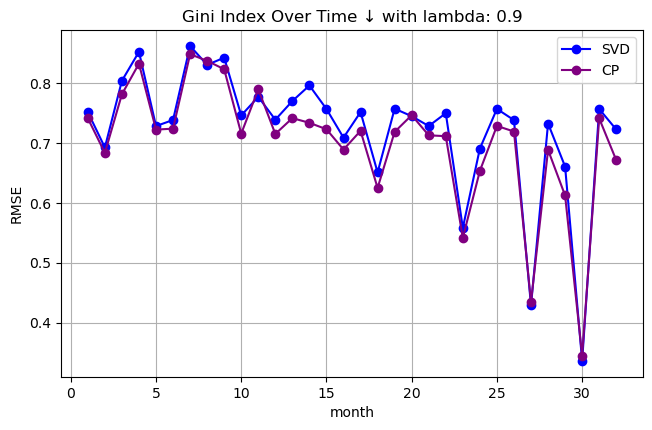

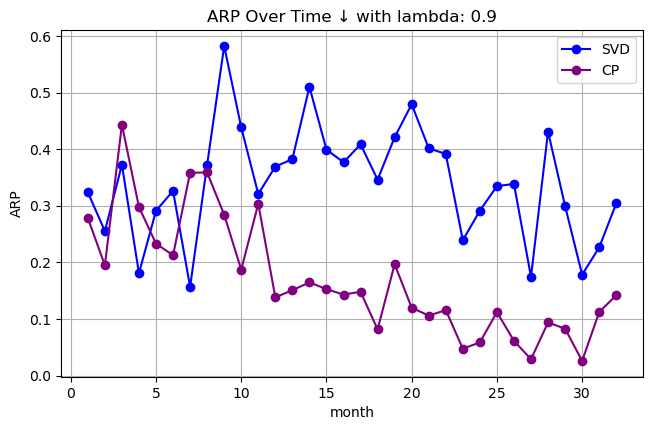

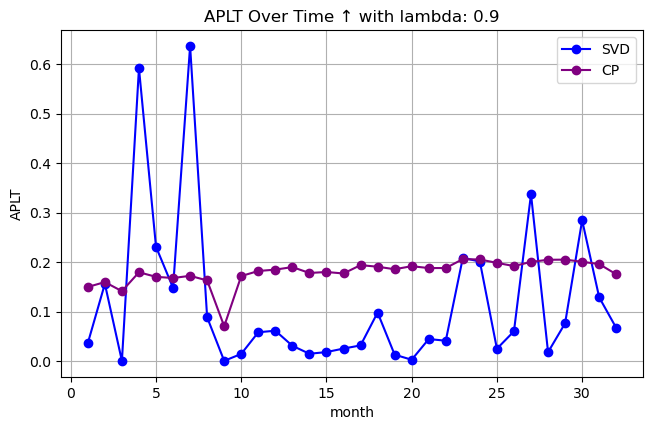

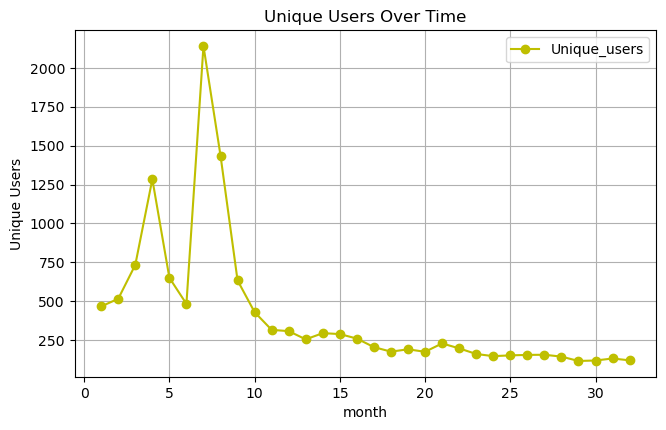

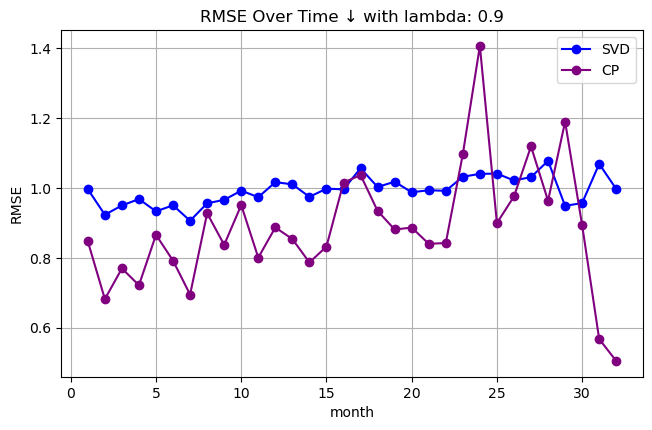

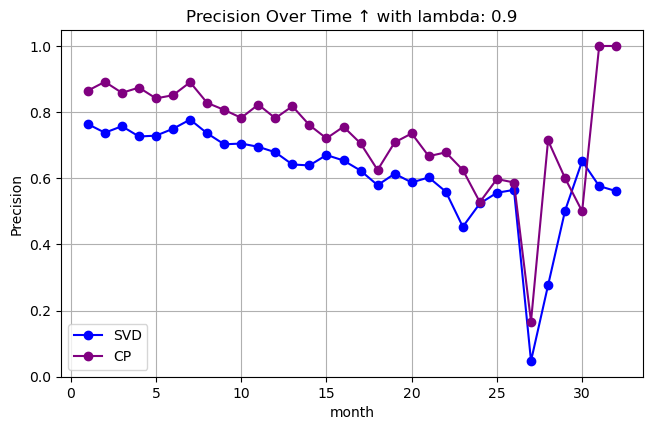

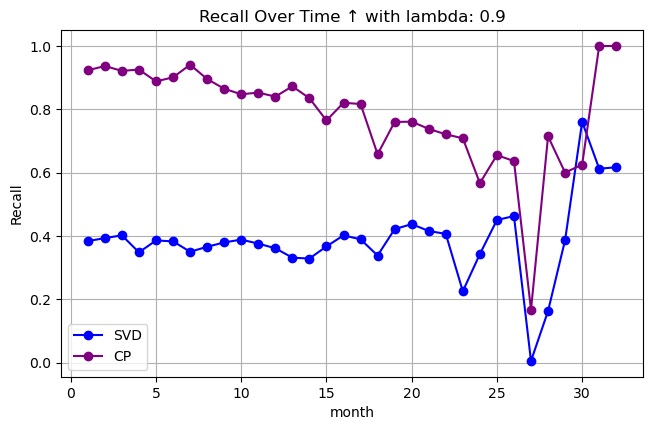

In [39]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='CP')
plt.title(f'Gini Index Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'gini{alpha}.png')
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='CP')
plt.title(f'ARP Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.savefig(f'arp{alpha}.png')
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='CP')
plt.title(f'APLT Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.savefig(f'aplt{alpha}.png')
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='CP')
plt.title(f'RMSE Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'rmse{alpha}.png')
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='CP')
plt.title(f'Precision Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.savefig(f'precision{alpha}.png')
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='CP')
plt.title(f'Recall Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.savefig(f'recall{alpha}.png')
plt.show()

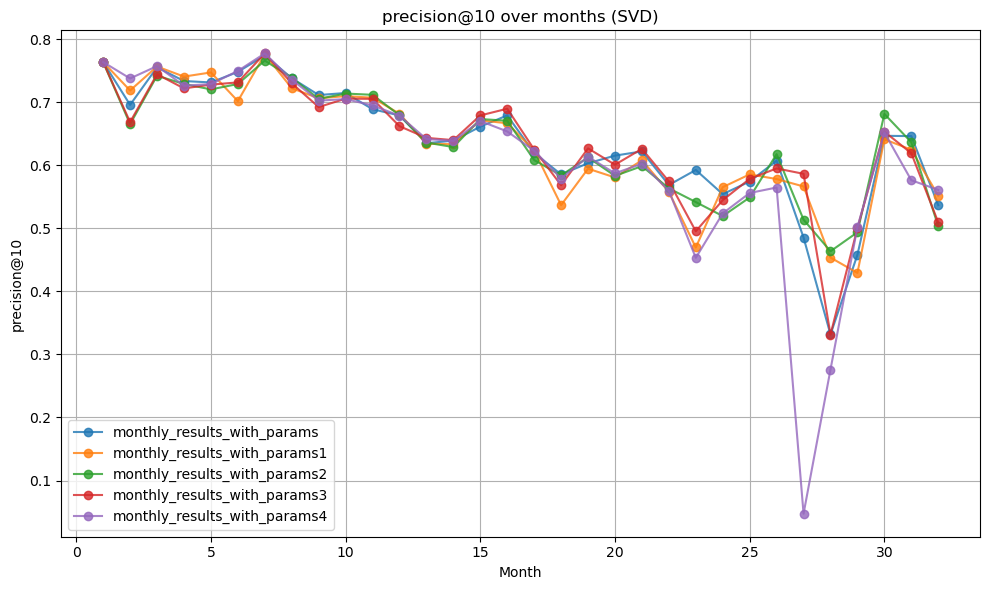

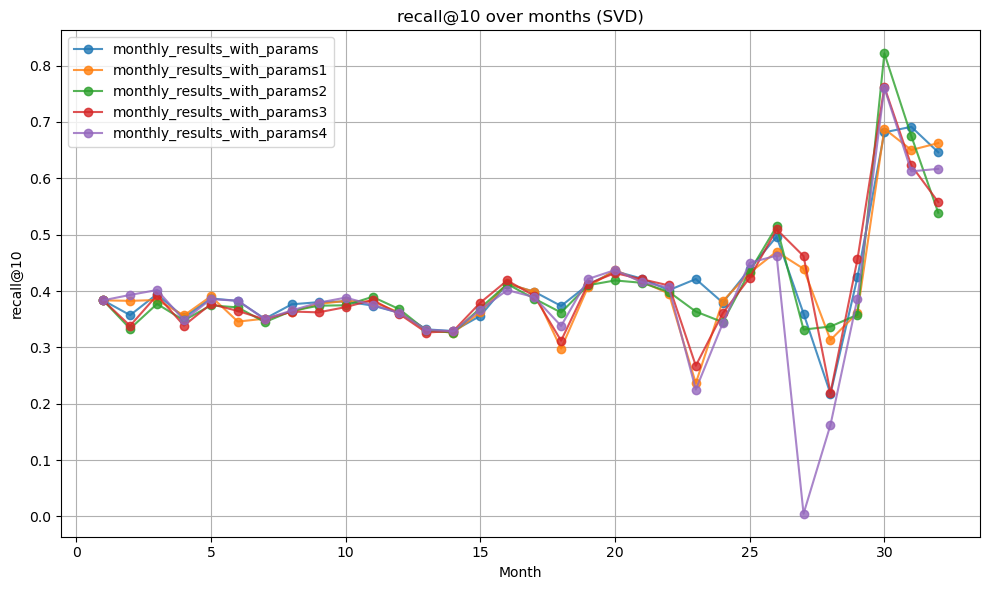

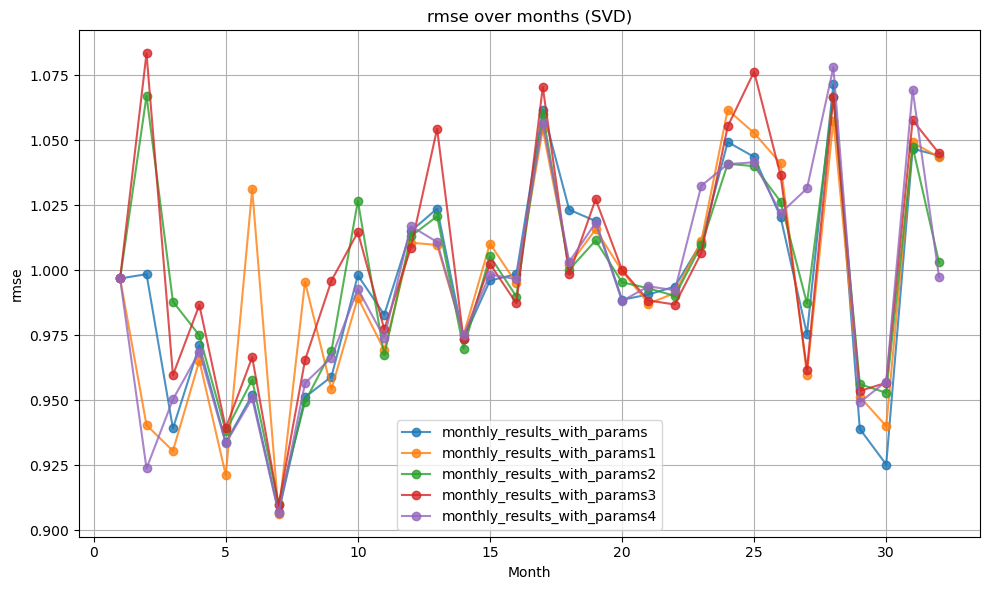

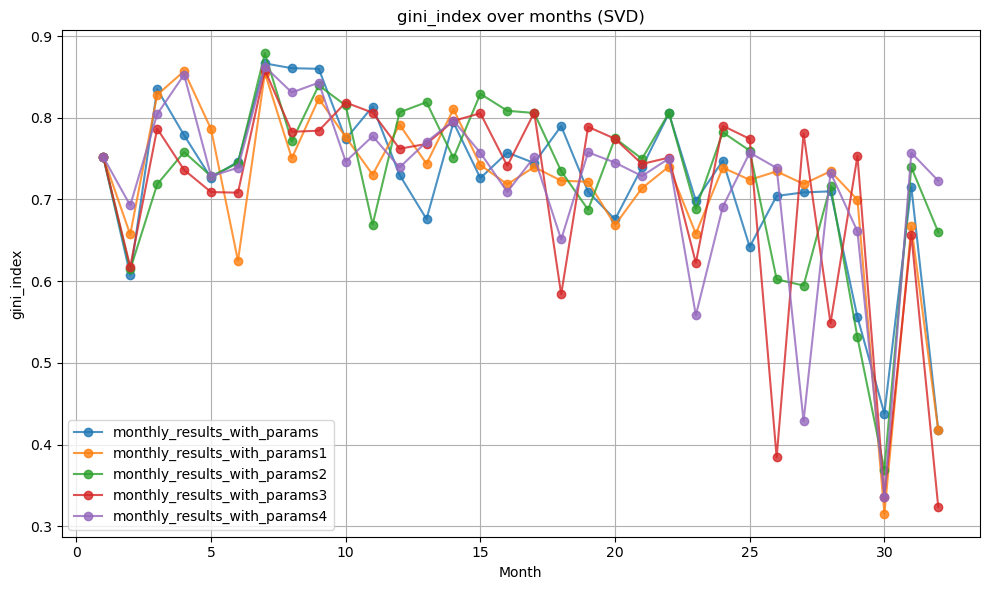

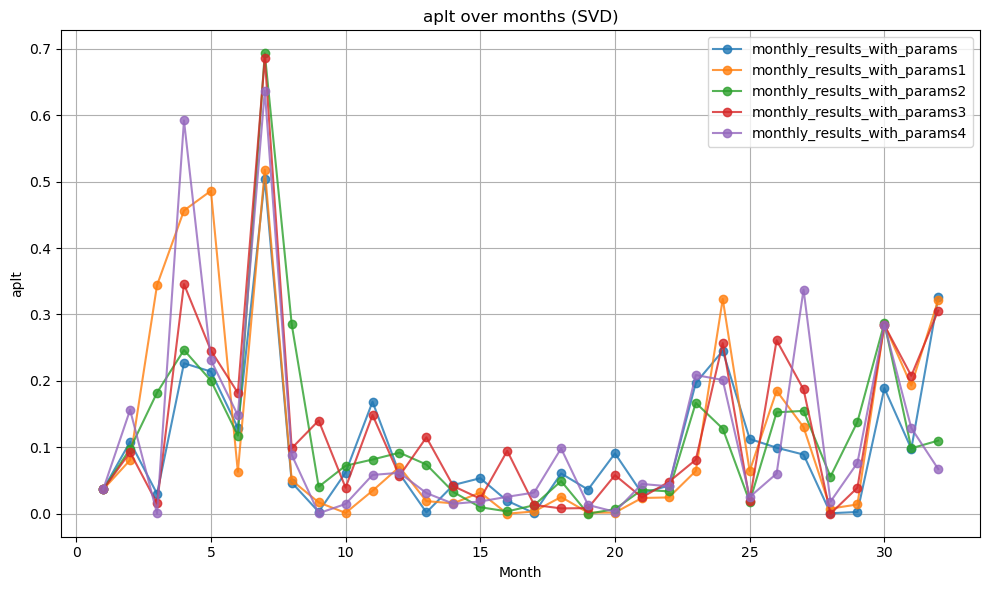

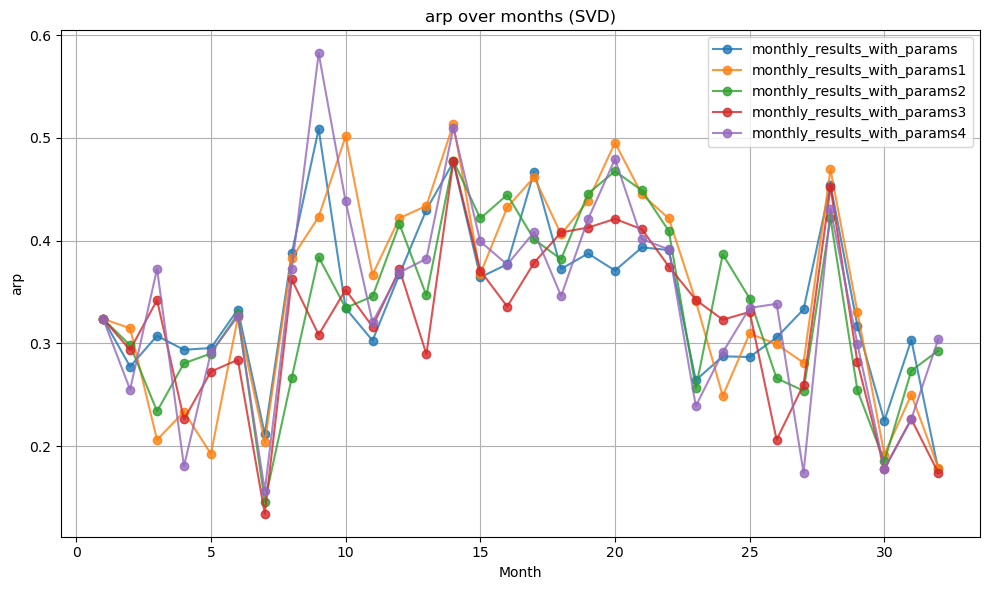

In [60]:


files = sorted(glob.glob("monthly_results_with_params*.csv"))
assert files, "No files found matching monthly_results_with_params*.csv"


dfs = []
for fp in files:
    run_id = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp).sort_values("month")
    df["run_id"] = run_id
    dfs.append(df)

all_runs = pd.concat(dfs, ignore_index=True)

# Metrics to plot
metrics = ["precision@10", "recall@10", "rmse", "gini_index", "aplt", "arp"]
available = [m for m in metrics if m in all_runs.columns]


for m in available:
    plt.figure(figsize=(10,6))
    for rid, sub in all_runs.groupby("run_id"):
        plt.plot(sub["month"], sub[m], marker="o", label=rid, alpha=0.8)
    plt.xlabel("Month")
    plt.ylabel(m)
    plt.title(f"{m} over months (SVD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = f"{m}_overlay_runs.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=150)
    plt.show()


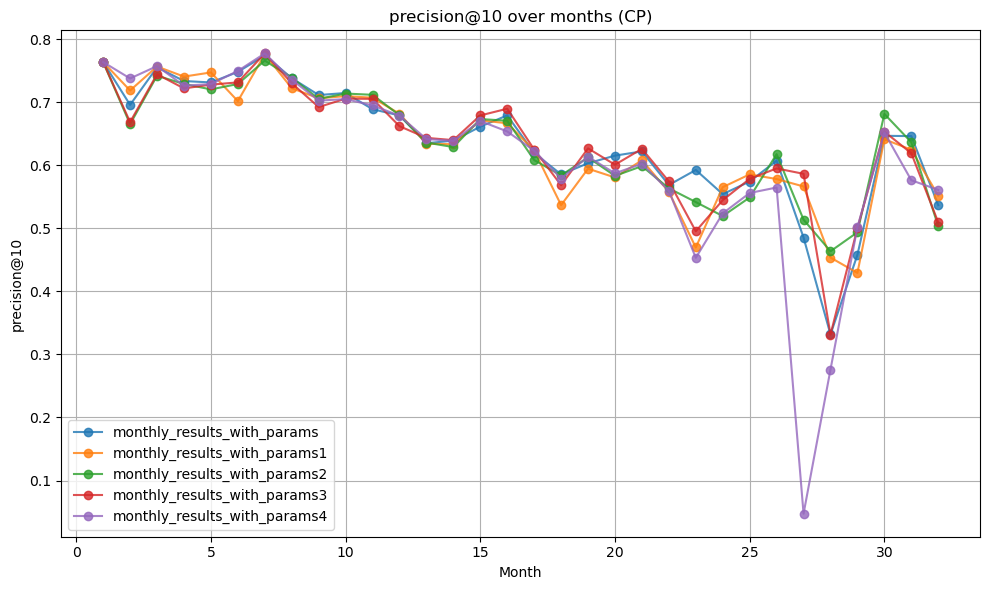

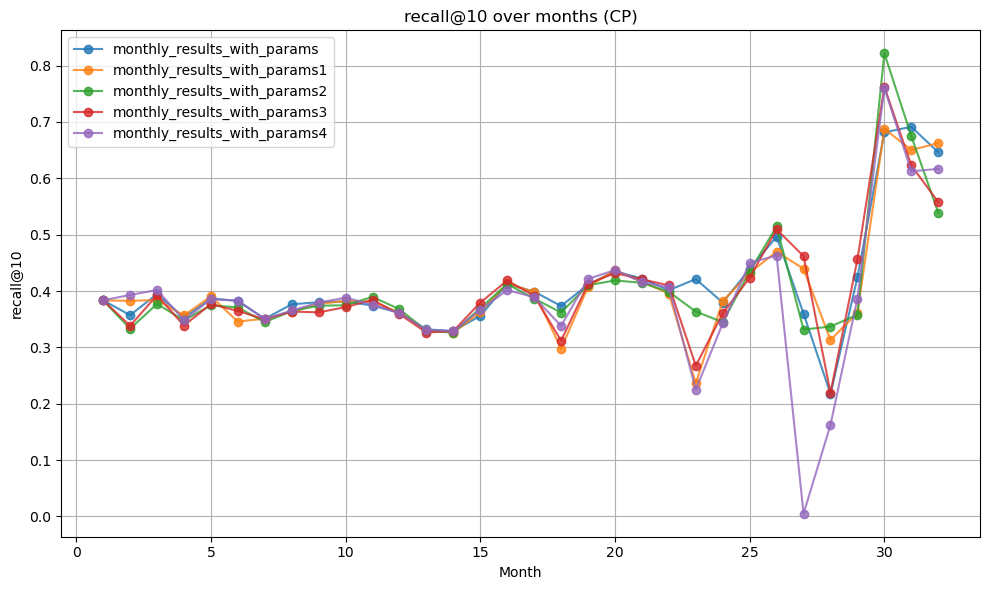

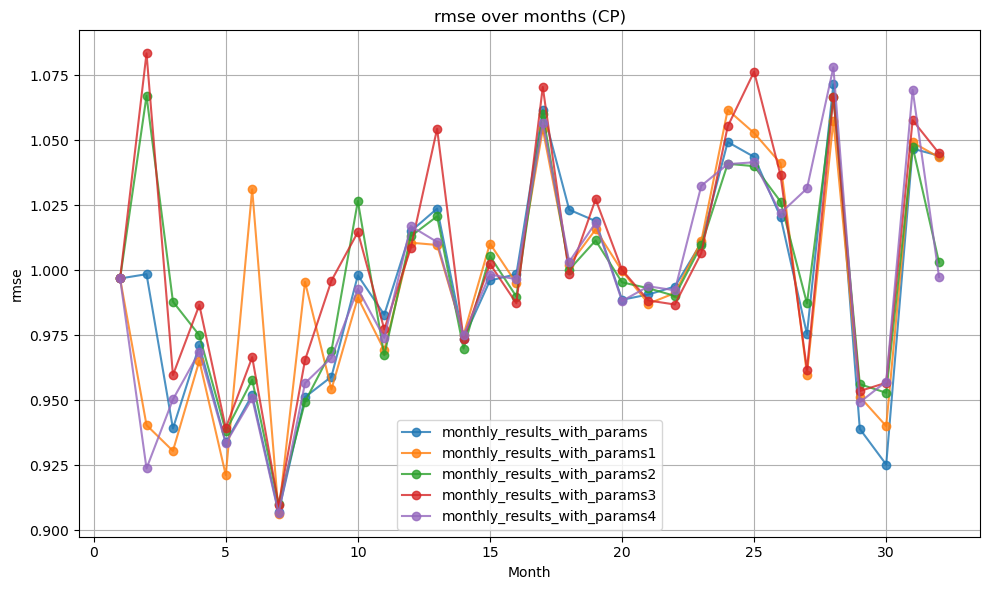

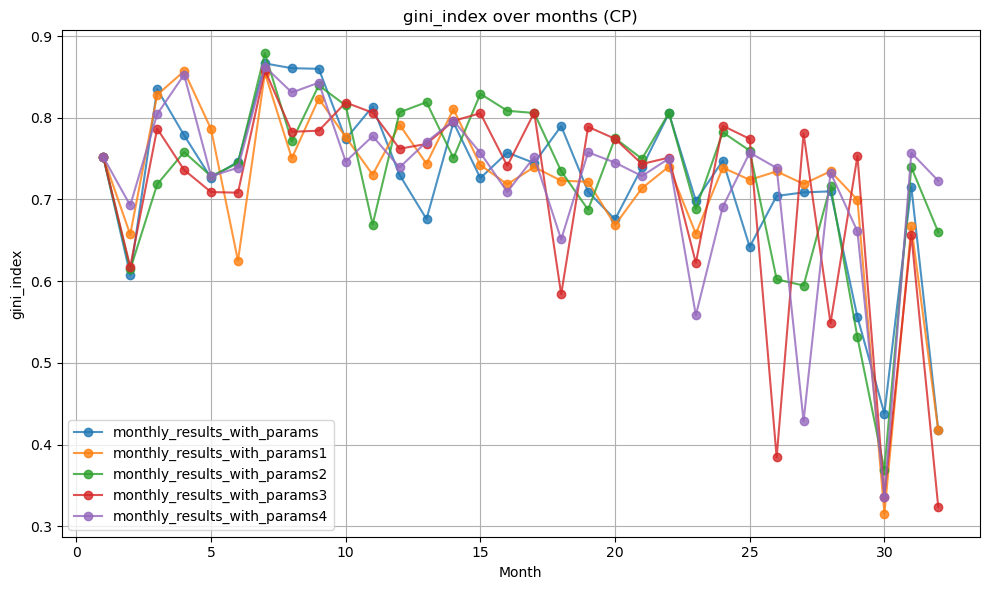

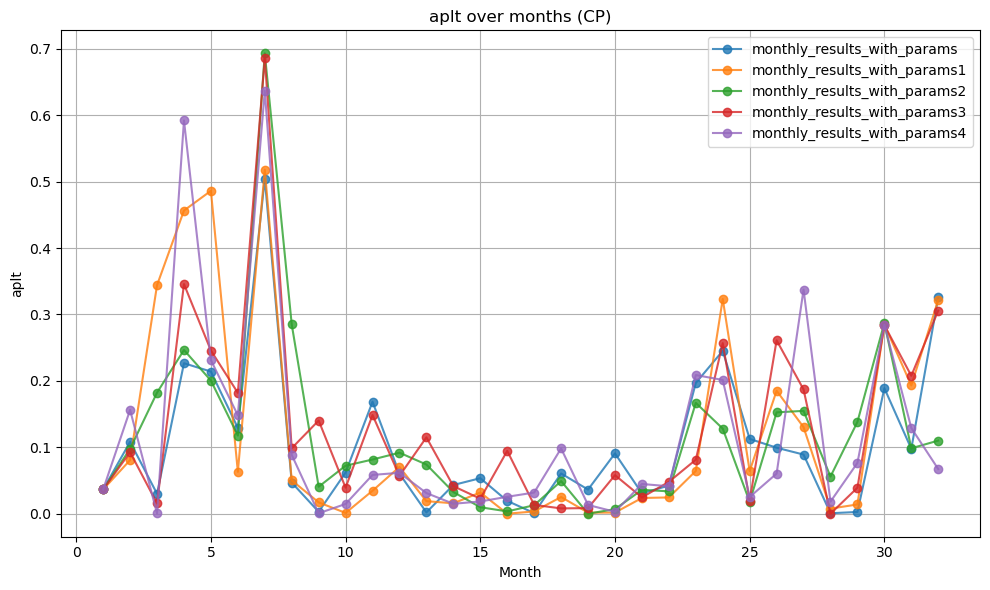

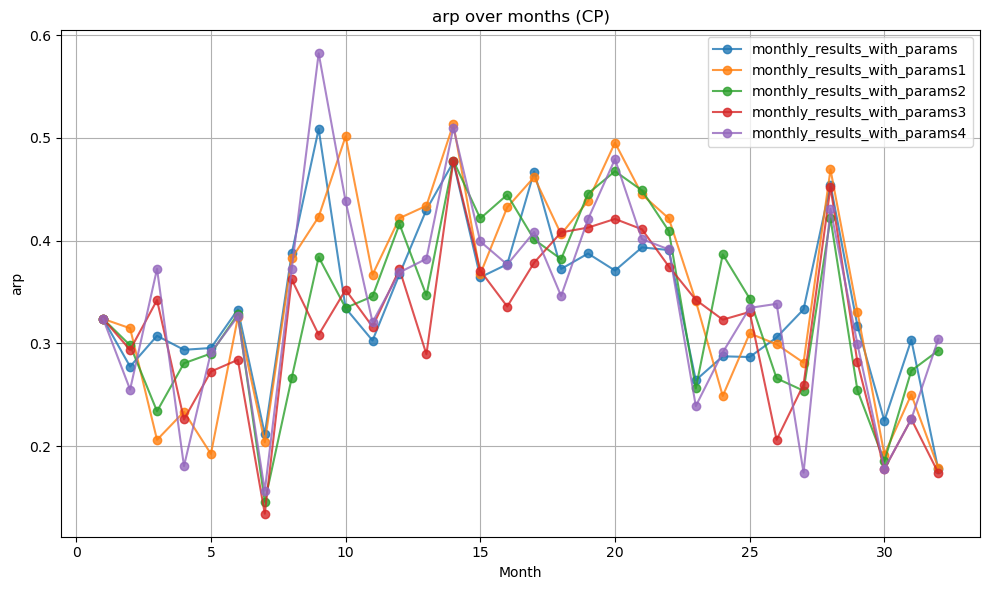

In [61]:
files = sorted(glob.glob("beyond_accuracy_per_month*.csv"))
assert files, "No files found matching monthly_results_with_params*.csv"

dfs_cp = []
for fp in files:
    run_id = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp).sort_values("month")
    df["run_id"] = run_id
    dfs_cp.append(df)
    
for m in available:
    plt.figure(figsize=(10,6))
    for rid, sub in all_runs.groupby("run_id"):
        plt.plot(sub["month"], sub[m], marker="o", label=rid, alpha=0.8)
    plt.xlabel("Month")
    plt.ylabel(m)
    plt.title(f"{m} over months (CP)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = f"{m}_overlay_runs.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=150)
    plt.show()

In [59]:
# Mean results of different parameters for SVD

files = sorted(glob.glob("monthly_results_with_params*.csv"))
assert files, "No monthly_results_*.csv files found."

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    df["run_id"] = os.path.splitext(os.path.basename(fp))[0]
    dfs.append(df)

all_main = pd.concat(dfs, ignore_index=True)

# Take mean and std for numeric columns per month
num_cols = all_main.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "month"]

agg_main = (all_main
            .groupby("month", as_index=False)[num_cols]
            .agg(["mean","std"])
            .reset_index())
agg_main.columns = ["month"] + [f"{c}_{s}" for c in num_cols for s in ("mean","std")]
agg_main = agg_main.sort_values("month")

display(agg_main)
#agg_main.to_csv("monthly_results_agg.csv", index=False)
#print("Wrote: monthly_results_agg.csv")


month  rmse_mean  rmse_std  num_active_users_mean  num_active_users_std  \
0       1   0.996869  0.000000                  466.0                   0.0   
1       2   1.002666  0.072058                  515.0                   0.0   
2       3   0.953563  0.022176                  733.0                   0.0   
3       4   0.973346  0.008243                 1284.0                   0.0   
4       5   0.933202  0.007149                  650.0                   0.0   
5       6   0.971703  0.033801                  482.0                   0.0   
6       7   0.907998  0.001803                 2141.0                   0.0   
7       8   0.963671  0.018875                 1436.0                   0.0   
8       9   0.968963  0.016222                  633.0                   0.0   
9      10   1.004352  0.015778                  429.0                   0.0   
10     11   0.974188  0.006282                  315.0                   0.0   
11     12   1.012831  0.003390                  307.0                   0.0   
12     13   1.023910  0.018099                  254.0                   0.0   
13     14   0.973448  0.002103                  294.0                   0.0   
14     15   1.002541  0.005637                  288.0                   0.0   
15     16   0.993471  0.004685                  259.0                   0.0   
16     17   1.060688  0.006210                  204.0                   0.0   
17     18   1.005465  0.010146                  175.0                   0.0   
18     19   1.018360  0.005814                  190.0                   0.0   
19     20   0.994430  0.005779                  174.0                   0.0   
20     21   0.990649  0.002896                  228.0                   0.0   
21     22   0.990873  0.002610                  196.0                   0.0   
22     23   1.014106  0.010438                  160.0                   0.0   
23     24   1.049638  0.009103                  146.0                   0.0   
24     25   1.050874  0.015097                  151.0                   0.0   
25     26   1.029324  0.009106                  154.0                   0.0   
26     27   0.983198  0.029176                  155.0                   0.0   
27     28   1.068088  0.007510                  143.0                   0.0   
28     29   0.949902  0.006604                  115.0                   0.0   
29     30   0.946475  0.013706                  118.0                   0.0   
30     31   1.054113  0.009600                  131.0                   0.0   
31     32   1.026585  0.024146                  119.0                   0.0   

    precision@10_mean  precision@10_std  recall@10_mean  recall@10_std  \
0            0.763715          0.000000        0.383474       0.000000   
1            0.697206          0.031411        0.360846       0.026433   
2            0.751178          0.007321        0.389979       0.009552   
3            0.730316          0.007193        0.348837       0.006781   
4            0.731157          0.009892        0.382879       0.006835   
5            0.731994          0.019328        0.369302       0.015296   
6            0.774266          0.004772        0.349209       0.002522   
7            0.733109          0.006973        0.366652       0.005532   
8            0.703601          0.007048        0.374528       0.007349   
9            0.709752          0.004483        0.379690       0.006657   
10           0.701673          0.009400        0.380893       0.006343   
11           0.676150          0.007985        0.362116       0.003272   
12           0.638083          0.004164        0.329831       0.002162   
13           0.636040          0.004736        0.327827       0.001412   
14           0.671037          0.006419        0.366772       0.008727   
15           0.671986          0.013507        0.411721       0.006240   
16           0.619911          0.006775        0.392923       0.005540   
17           0.570746          0.020096        0.336597       0.

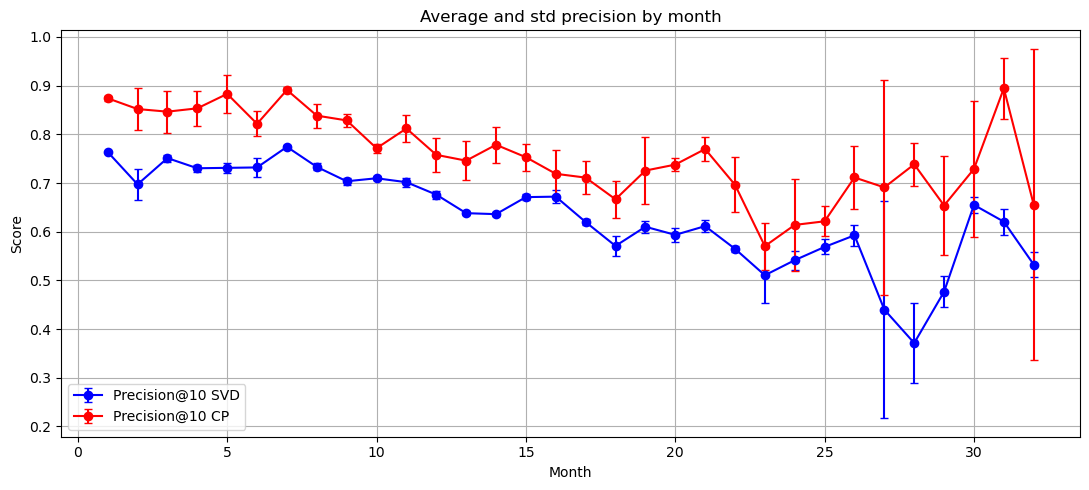

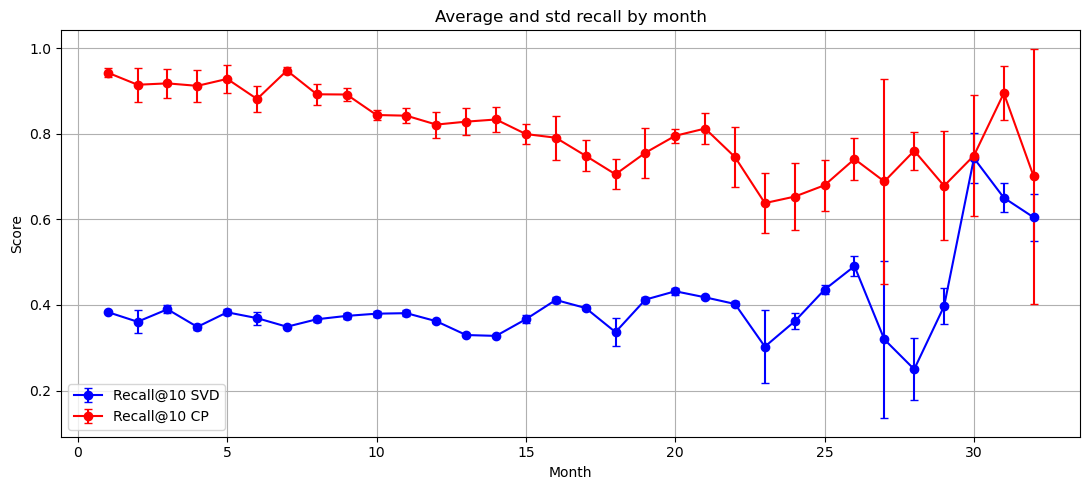

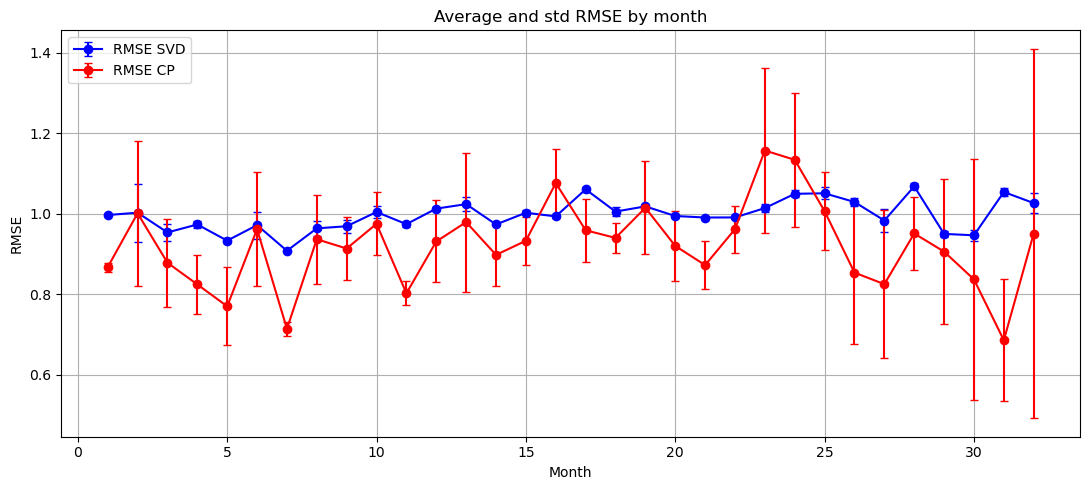

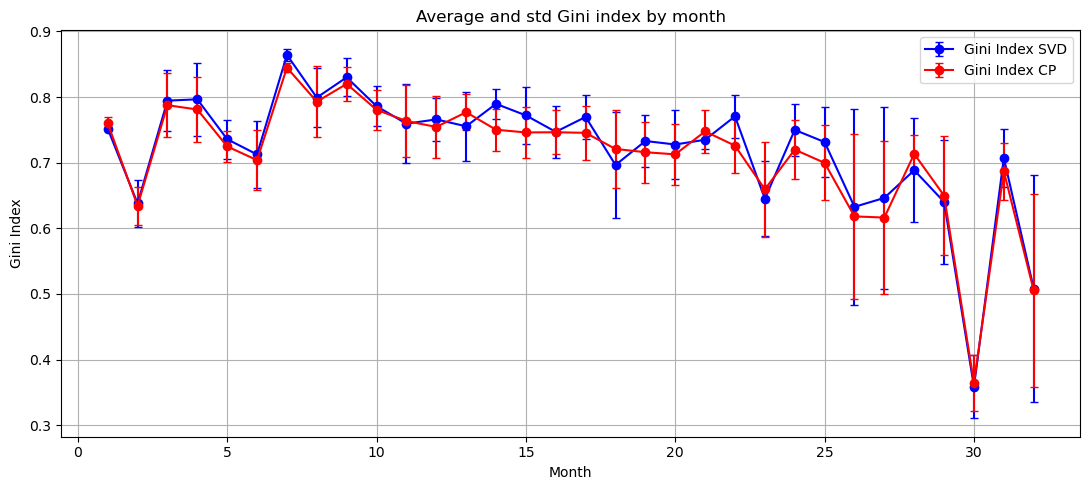

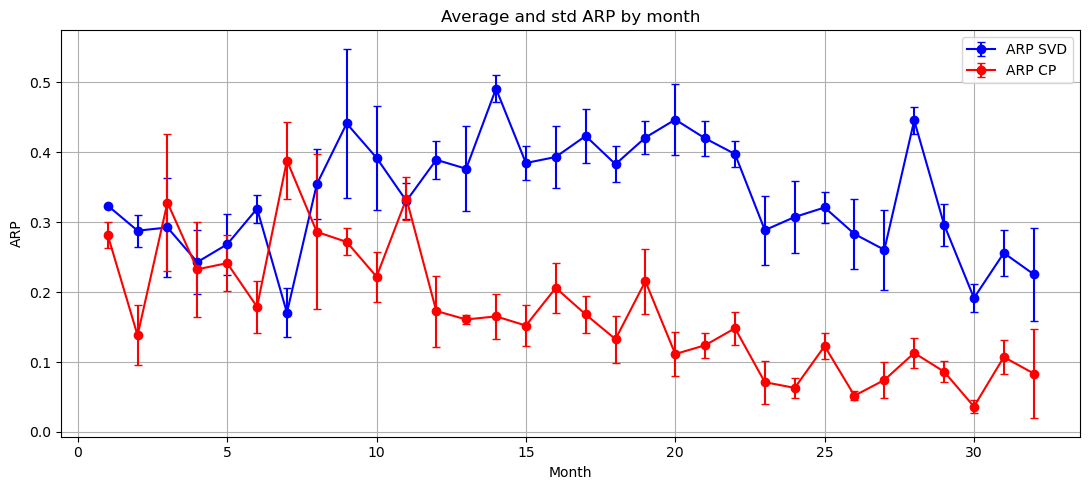

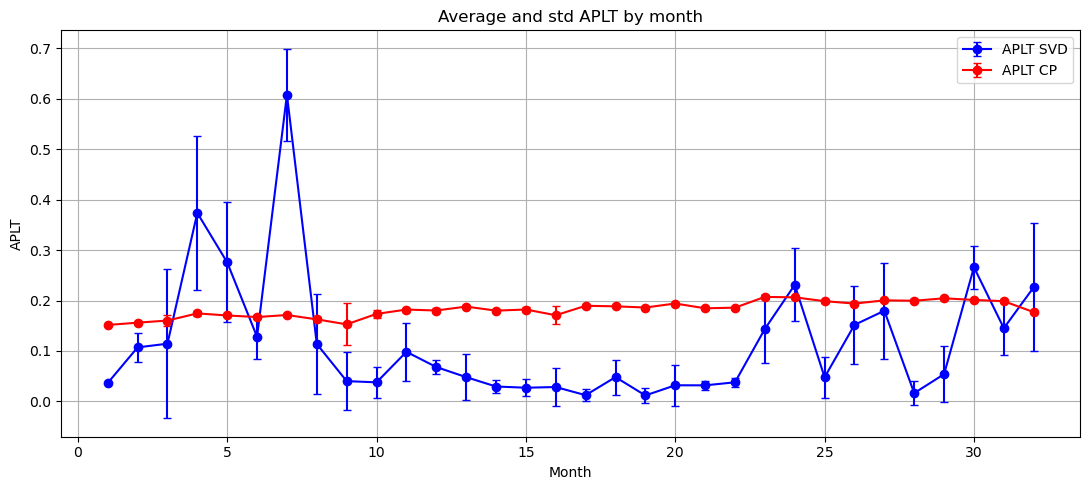

In [133]:
def plot_with_errorbars(df, metric_base, *,
                        x_col="month",
                        color=None,
                        label=None):
    mean_col = f"{metric_base}_mean"
    std_col  = f"{metric_base}_std"
    if mean_col not in df.columns or std_col not in df.columns:
        print(f"Skipping '{metric_base}': columns '{mean_col}' / '{std_col}' not found.")
        return
    df_plot = df.sort_values(x_col)
    x = df_plot[x_col].values
    y = df_plot[mean_col].values
    yerr = df_plot[std_col].values
    
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3, color=color, label=label)
    
plt.figure(figsize=(11, 5))

plot_with_errorbars(agg_main, "precision@10", color='blue', label='Precision@10 SVD')
plot_with_errorbars(agg_cp, "precision@10", color='red', label='Precision@10 CP')

#Precision
plt.xlabel("Month")
plt.ylabel("Score")
plt.title("Average and std precision by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Recall@10
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "recall@10", color='blue', label='Recall@10 SVD')
plot_with_errorbars(agg_cp, "recall@10", color='red', label='Recall@10 CP')
plt.xlabel("Month")
plt.ylabel("Score")
plt.title("Average and std recall by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "rmse", color='blue', label='RMSE SVD')
plot_with_errorbars(agg_cp, "rmse", color='red', label='RMSE CP')
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.title("Average and std RMSE by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gini Index
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "gini_index", color='blue', label='Gini Index SVD')
plot_with_errorbars(agg_cp, "gini_index", color='red', label='Gini Index CP')
plt.xlabel("Month")
plt.ylabel("Gini Index")
plt.title("Average and std Gini index by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARP
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "arp", color='blue', label='ARP SVD')
plot_with_errorbars(agg_cp, "arp", color='red', label='ARP CP')
plt.xlabel("Month")
plt.ylabel("ARP")
plt.title("Average and std ARP by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# APLT
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "aplt", color='blue', label='APLT SVD')
plot_with_errorbars(agg_cp, "aplt", color='red', label='APLT CP')
plt.xlabel("Month")
plt.ylabel("APLT")
plt.title("Average and std APLT by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


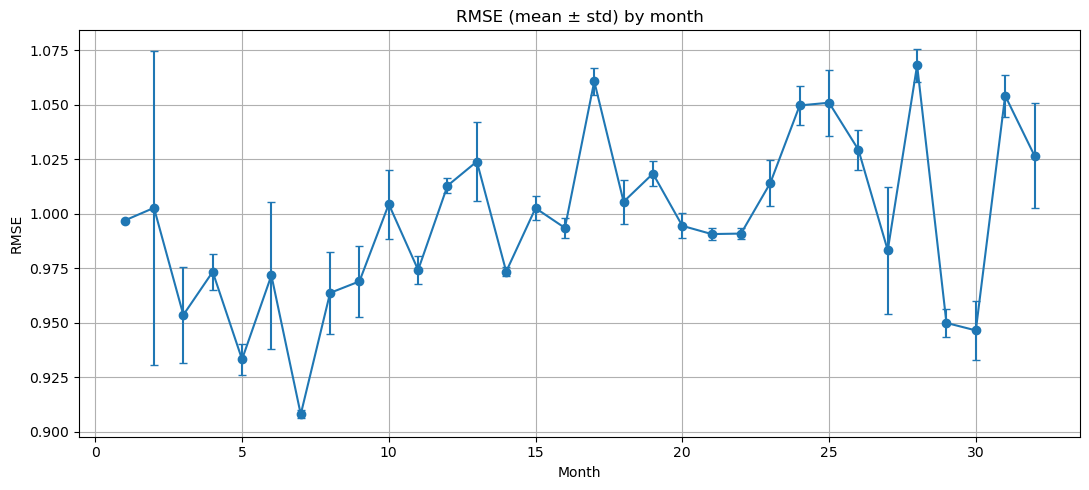

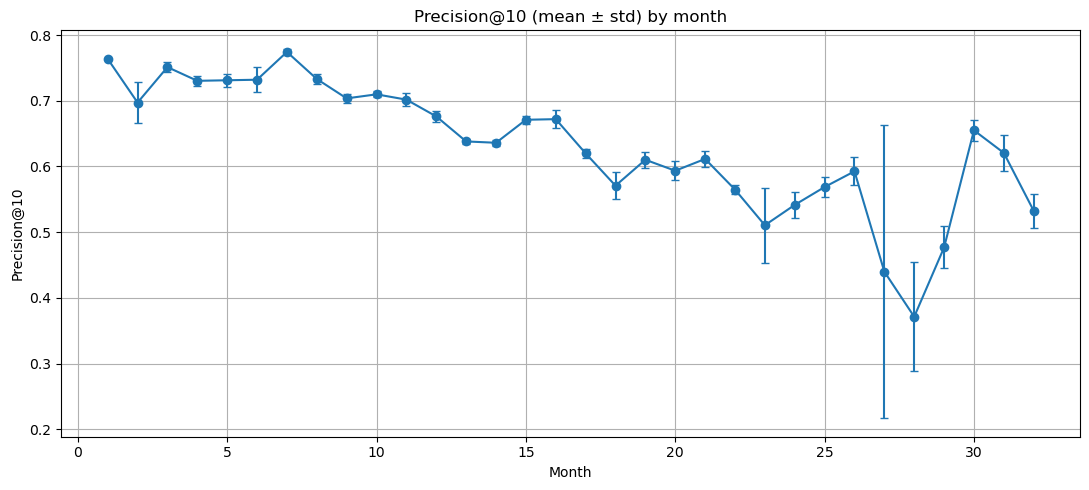

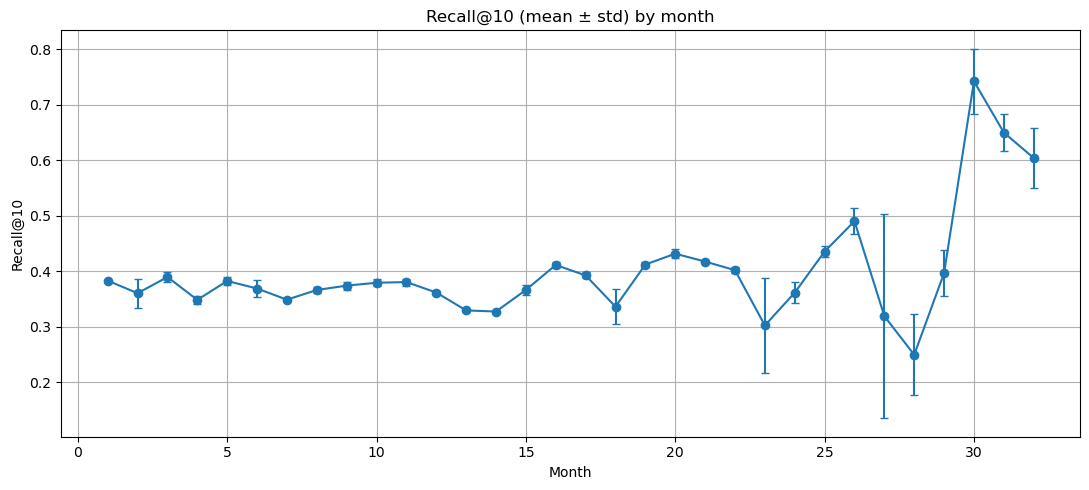

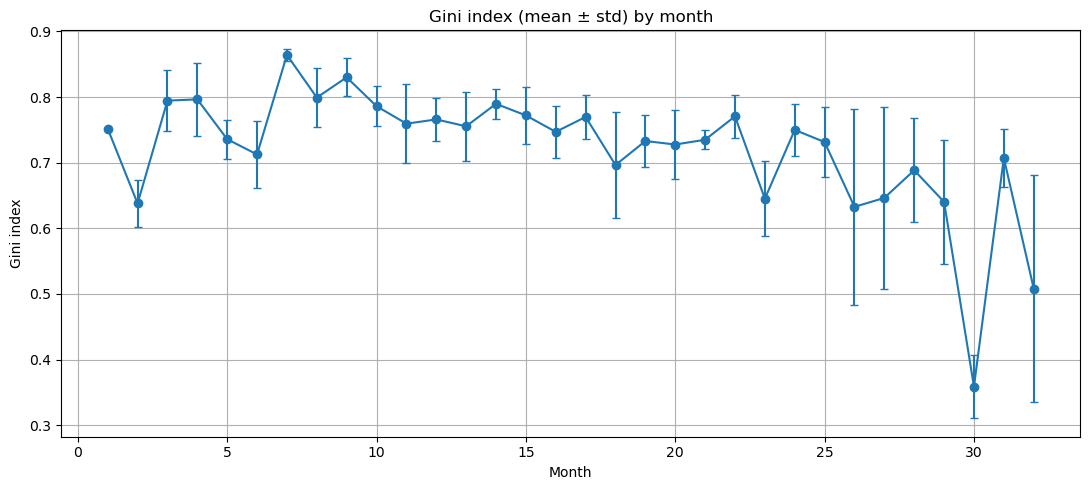

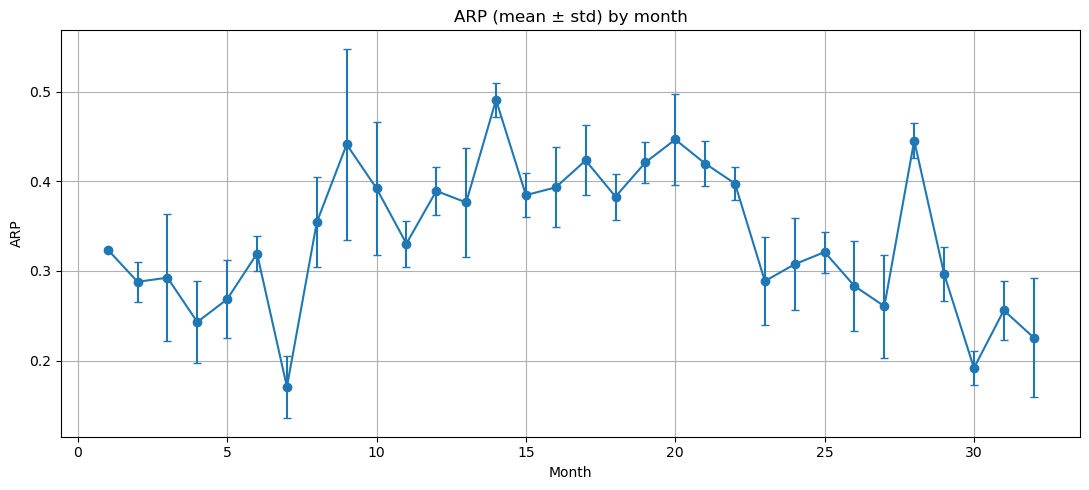

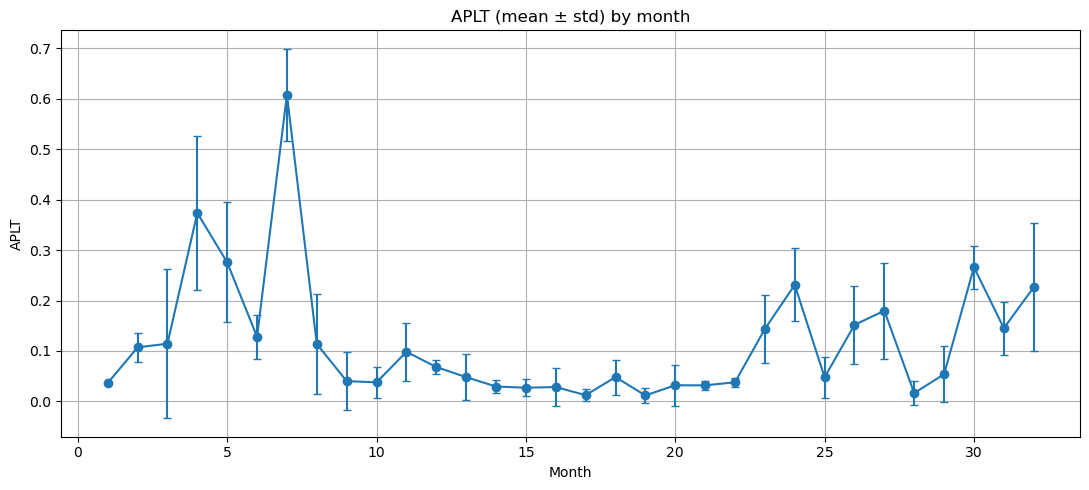

In [130]:
def plot_with_errorbars2(df, metric_base, *,
                        x_col="month",
                        title=None,
                        x_label="Month",
                        y_label=None,
                        save_as=None):
    mean_col = f"{metric_base}_mean"
    std_col  = f"{metric_base}_std"
    if mean_col not in df.columns or std_col not in df.columns:
        print(f"Skipping '{metric_base}': columns '{mean_col}' / '{std_col}' not found.")
        return

    df_plot = df.sort_values(x_col)
    x = df_plot[x_col].values
    y = df_plot[mean_col].values
    yerr = df_plot[std_col].values

    plt.figure(figsize=(11, 5))
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3)
    plt.xlabel(x_label)
    plt.ylabel(y_label if y_label else metric_base)
    plt.title(title if title else f"{metric_base} (mean ± std) by month")
    plt.grid(True)
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, bbox_inches='tight', dpi=150)
    plt.show()

plot_with_errorbars2(
    agg_main, "rmse",
    title="RMSE (mean ± std) by month",
    y_label="RMSE"
)

plot_with_errorbars2(
    agg_main, "precision@10",
    title="Precision@10 (mean ± std) by month",
    y_label="Precision@10"
)

plot_with_errorbars2(
    agg_main, "recall@10",
    title="Recall@10 (mean ± std) by month",
    y_label="Recall@10"
)


plot_with_errorbars2(
    agg_main, "gini_index",
    title="Gini index (mean ± std) by month",
    y_label="Gini index"
)



plot_with_errorbars2(
    agg_main, "arp",
    title="ARP (mean ± std) by month",
    y_label="ARP"
)


plot_with_errorbars2(
    agg_main, "aplt",
    title="APLT (mean ± std) by month",
    y_label="APLT"
)


In [131]:
# Mean results of CP with different SVD parameters 

files = sorted(glob.glob("beyond_accuracy_per_month*.csv"))
assert files, "No beyond_accuracy_per_month_*.csv files found."

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    df["run_id"] = os.path.splitext(os.path.basename(fp))[0]
    dfs.append(df)

all_cp = pd.concat(dfs, ignore_index=True)

num_cols = all_cp.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "month"]

agg_cp = (all_cp
          .groupby("month", as_index=False)[num_cols]
          .agg(["mean","std"])
          .reset_index())
agg_cp.columns = ["month"] + [f"{c}_{s}" for c in num_cols for s in ("mean","std")]
agg_cp = agg_cp.sort_values("month")

display(agg_cp)
#agg_cp.to_csv("beyond_accuracy_per_month_agg.csv", index=False)


month  gini_index_mean  gini_index_std  arp_mean   arp_std  aplt_mean  \
0       1         0.760055        0.010268  0.281842  0.019004   0.151545   
1       2         0.634479        0.028646  0.138223  0.043035   0.156078   
2       3         0.787638        0.048362  0.328129  0.098121   0.160300   
3       4         0.781112        0.049947  0.232672  0.067728   0.174439   
4       5         0.724772        0.023650  0.241489  0.039665   0.170369   
5       6         0.703912        0.045773  0.179016  0.037204   0.167220   
6       7         0.844860        0.007253  0.388235  0.054595   0.171266   
7       8         0.793037        0.054541  0.286219  0.110890   0.162632   
8       9         0.820102        0.026406  0.271844  0.019366   0.152796   
9      10         0.780679        0.030282  0.222142  0.035651   0.173473   
10     11         0.763492        0.055363  0.333704  0.031101   0.182032   
11     12         0.754518        0.047676  0.173032  0.050778   0.180195   
12     13         0.776930        0.027345  0.160909  0.007029   0.187953   
13     14         0.750282        0.031764  0.165333  0.032153   0.179932   
14     15         0.746110        0.038445  0.152225  0.028771   0.182153   
15     16         0.746420        0.033430  0.206121  0.035342   0.170811   
16     17         0.745522        0.040862  0.168134  0.026102   0.189510   
17     18         0.720944        0.059838  0.132737  0.033408   0.188457   
18     19         0.716027        0.046219  0.215606  0.046235   0.186105   
19     20         0.712728        0.046250  0.111509  0.031860   0.194023   
20     21         0.747701        0.033232  0.124043  0.018220   0.184561   
21     22         0.725991        0.041181  0.148333  0.023700   0.185816   
22     23         0.659476        0.072752  0.071184  0.030837   0.207125   
23     24         0.719909        0.044769  0.063052  0.014386   0.206301   
24     25         0.699794        0.057080  0.122855  0.018635   0.198675   
25     26         0.618214        0.125356  0.051897  0.006490   0.193896   
26     27         0.616417        0.116880  0.074336  0.026164   0.200258   
27     28         0.713452        0.028128  0.112974  0.021904   0.199580   
28     29         0.649847        0.090383  0.086257  0.014600   0.204348   
29     30         0.364395        0.042553  0.036319  0.009630   0.201186   
30     31         0.686944        0.043785  0.107187  0.024013   0.198626   
31     32         0.505503        0.147232  0.083632  0.064011   0.176975   

    aplt_std  rmse_mean  rmse_std  precision@10_mean  precision@10_std  \
0   0.000864   0.867134  0.010882           0.874027          0.005118   
1   0.002423   1.001191  0.180285           0.851933          0.042460   
2   0.011487   0.878256  0.108936           0.846568          0.043006   
3   0.004323   0.824258  0.073517           0.853396          0.035727   
4   0.001404   0.769842  0.097050           0.883082          0.038895   
5   0.002282   0.961655  0.142208           0.821598          0.025890   
6   0.001058   0.713881  0.017598           0.891114          0.006793   
7   0.004372   0.936624  0.110623           0.838423          0.024481   
8   0.041635   0.913542  0.079281           0.828587          0.013850   
9   0.008146   0.974965  0.077957           0.771369          0.008751   
10  0.003885   0.802128  0.029938           0.812039          0.027495   
11  0.004926   0.931094  0.102012           0.757842          0.034793   
12  0.002980   0.979233  0.173053           0.745914          0.040631   
13  0.002825   0.897729  0.077158           0.778550          0.037243   
14  0.004505   0.932800  0.060054           0.752988          0.028135   
15  0.017995   1.076357  0.085785           0.718914          0.049282   
16  0.003424   0.958952  0.078011           0.711103          0.033166   
17  0.001780   0.940001  0.037176           0.666569          0.037978   
18  0.003658   1.014959  0.116190           0.725549    

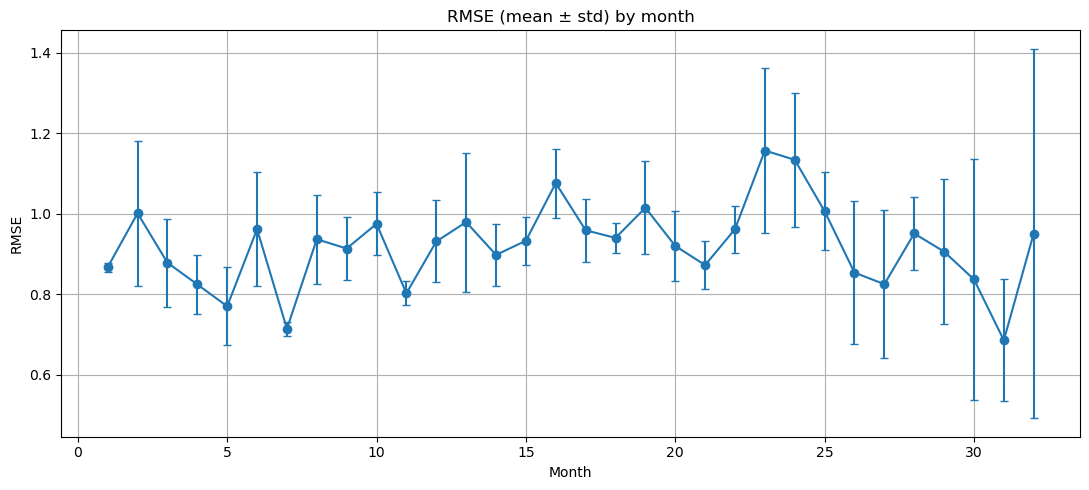

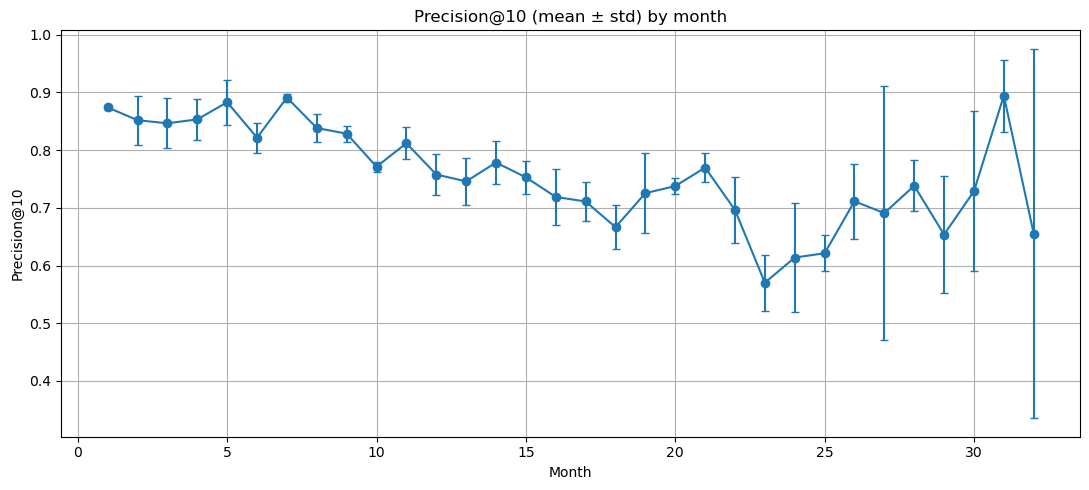

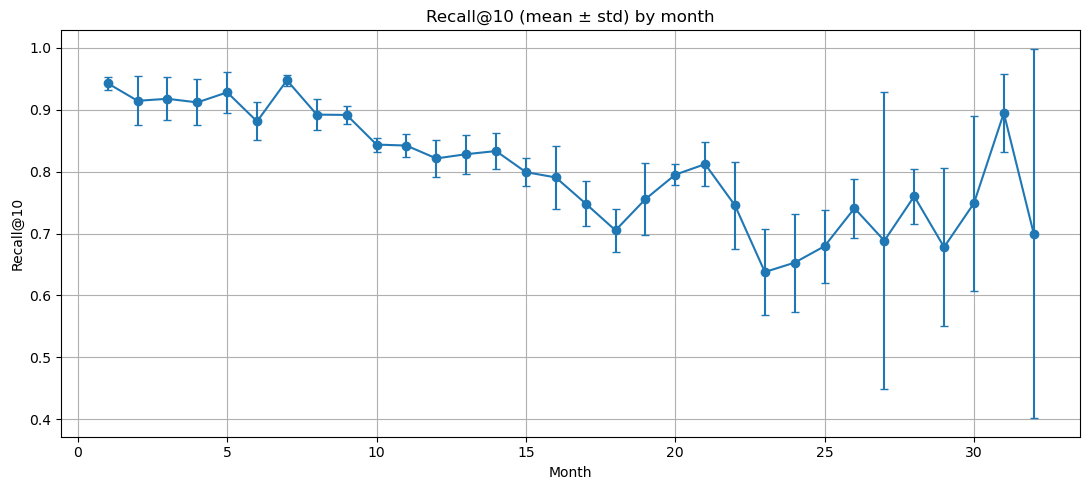

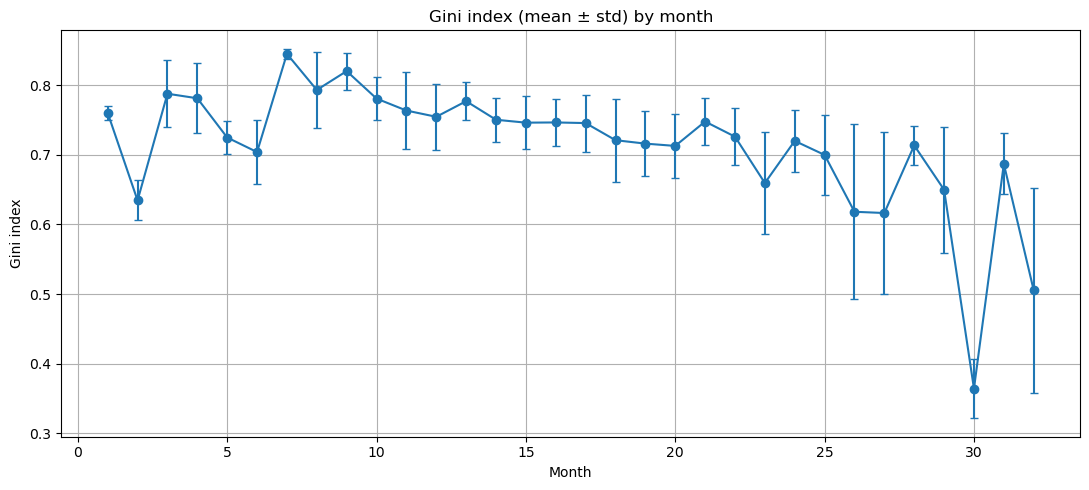

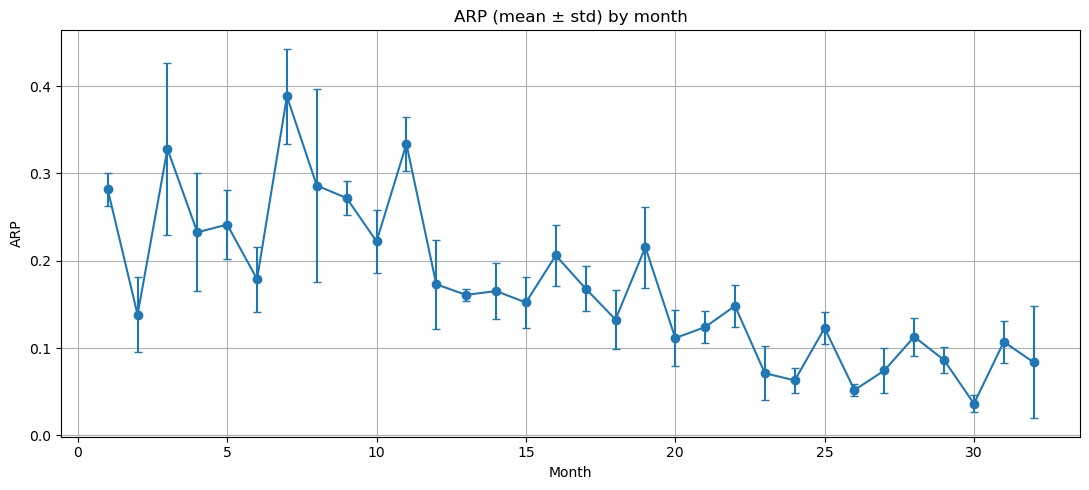

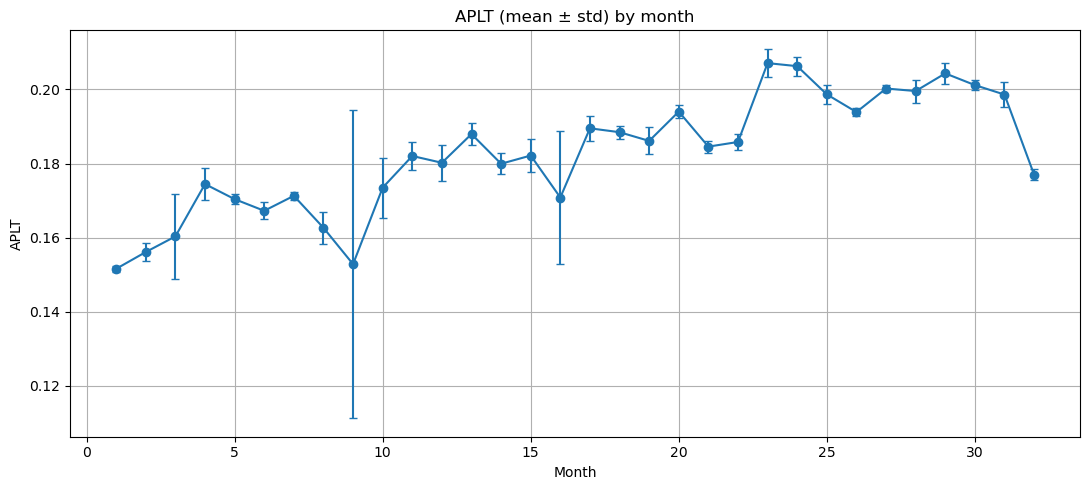

In [132]:
plot_with_errorbars2(
    agg_cp, "rmse",
    title="RMSE (mean ± std) by month",
    y_label="RMSE"
)

plot_with_errorbars2(
    agg_cp, "precision@10",
    title="Precision@10 (mean ± std) by month",
    y_label="Precision@10"
)

plot_with_errorbars2(
    agg_cp, "recall@10",
    title="Recall@10 (mean ± std) by month",
    y_label="Recall@10"
)

plot_with_errorbars2(
    agg_cp, "gini_index",
    title="Gini index (mean ± std) by month",
    y_label="Gini index"
)

plot_with_errorbars2(
    agg_cp, "arp",
    title="ARP (mean ± std) by month",
    y_label="ARP"
)

plot_with_errorbars2(
    agg_cp, "aplt",
    title="APLT (mean ± std) by month",
    y_label="APLT"
)

In [79]:
"""
# Mean results of the different parameters for SVD befor Evaluate_over_months()

csv_files = sorted(glob.glob("svd_val_test_summary*.csv"))
if not csv_files:
    raise FileNotFoundError("Did not find any 'svd_val_test_summary*.csv' in the folder.")

runs = []
for fp in csv_files:
    df = pd.read_csv(fp)
    df['run_id'] = os.path.splitext(os.path.basename(fp))[0] 
    runs.append(df)

all_runs = pd.concat(runs, ignore_index=True)

metrics = ['val_precision@10','val_rmse','test_precision@10','test_recall@10','test_rmse']
agg = (all_runs
       .groupby('month', as_index=False)[metrics]
       .agg(['mean','std'])
       .reset_index())

agg.columns = ['month'] + [f"{m}_{stat}" for m in metrics for stat in ('mean','std')]
agg = agg.sort_values('month')

agg['test_precision_cv_%'] = 100 * (agg['test_precision@10_std'] / agg['test_precision@10_mean']).replace([np.inf, -np.inf], np.nan)

display(agg)
#agg.to_csv("svd_val_test_summary_agg.csv", index=False)
"""


'\n# Mean results of the different parameters for SVD befor Evaluate_over_months()\n\ncsv_files = sorted(glob.glob("svd_val_test_summary*.csv"))\nif not csv_files:\n    raise FileNotFoundError("Did not find any \'svd_val_test_summary*.csv\' in the folder.")\n\nruns = []\nfor fp in csv_files:\n    df = pd.read_csv(fp)\n    df[\'run_id\'] = os.path.splitext(os.path.basename(fp))[0] \n    runs.append(df)\n\nall_runs = pd.concat(runs, ignore_index=True)\n\nmetrics = [\'val_precision@10\',\'val_rmse\',\'test_precision@10\',\'test_recall@10\',\'test_rmse\']\nagg = (all_runs\n       .groupby(\'month\', as_index=False)[metrics]\n       .agg([\'mean\',\'std\'])\n       .reset_index())\n\nagg.columns = [\'month\'] + [f"{m}_{stat}" for m in metrics for stat in (\'mean\',\'std\')]\nagg = agg.sort_values(\'month\')\n\nagg[\'test_precision_cv_%\'] = 100 * (agg[\'test_precision@10_std\'] / agg[\'test_precision@10_mean\']).replace([np.inf, -np.inf], np.nan)\n\ndisplay(agg)\n#agg.to_csv("svd_val_test_s

In [70]:
# Monthy index
df = ratings.copy()
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp')
df['ym'] = df['timestamp'].dt.to_period('M')
months = np.array(sorted(df['ym'].unique(), key=lambda x: (x.year, x.month)))

# Monthly users
users_per_month = {
    m: set(df.loc[df['ym'] == m, 'userId'].unique())
    for m in months
}


users_ever_before = []          # users appearing before month i
prefix_seen = set()
for m in months:
    users_ever_before.append(prefix_seen.copy())
    prefix_seen |= users_per_month[m]

users_ever_after = {}           # users appearing after month i
suffix_seen = set()
for m in reversed(months):
    users_ever_after[m] = suffix_seen.copy()
    suffix_seen |= users_per_month[m]

rows = []
for i, m in enumerate(months):
    users_now  = users_per_month[m]
    users_prev = users_per_month[months[i-1]] if i > 0 else set()
    users_next = users_per_month[months[i+1]] if i < len(months)-1 else set()

    active = len(users_now)

    new_users = users_now - users_prev

    # first time observed
    first_time_new = users_now - users_ever_before[i]

    returning_after_pause = (users_now & users_ever_before[i]) - users_prev

    # Disappearing next month
    churn_next = users_now - users_next if i < len(months)-1 else set()

    # Permanently disappeared
    permanent_churn = users_now - users_ever_after[m]

    retention_next = (len(users_now & users_next) / active) if (active > 0 and i < len(months)-1) else float('nan')

    rows.append({
        #'month': str(m),
        'month_idx': i+1,
        'active_users': active,
        'new_users': len(new_users),
        'first_time_new': len(first_time_new),
        'returning_after_pause': len(returning_after_pause),
        'churned_next_month': len(churn_next) if i < len(months)-1 else float('nan'),
        'permanent_churn': len(permanent_churn),
        #'retention_rate_next_month': round(retention_next, 4) if retention_next == retention_next else float('nan'),  # NaN-safe
        #'net_user_change_vs_next': (len(users_next) - active) if i < len(months)-1 else float('nan'),
    })

user_flow = pd.DataFrame(rows)
display(user_flow)
"""
# New and disappearing users
rows = []
for i, m in enumerate(months):
    users_now = users_per_month[m]
    users_prev = users_per_month[months[i-1]] if i > 0 else set()
    users_next = users_per_month[months[i+1]] if i < len(months)-1 else set()

    active = len(users_now)
    new_users = len(users_now - users_prev)                 
    churned = len(users_now - users_next) if i < len(months)-1 else np.nan  

    churn_rate = (churned / active) if (active > 0 and pd.notna(churned)) else np.nan
    retention_rate = (1 - churn_rate) if pd.notna(churn_rate) else np.nan

    rows.append({
        'month': str(m),                  
        'active_users': active,
        'new_users': new_users,
        'churned_next_month': churned,
        'retention_rate_next_month': round(retention_rate, 4) if pd.notna(retention_rate) else np.nan,
        'net_user_change_vs_next': (len(users_next) - active) if i < len(months)-1 else np.nan
    })

user_flow = pd.DataFrame(rows)

# Month


display(user_flow)
# user_flow.to_csv("user_flow_by_month.csv", index=False)
"""
user_flow['month_idx'] = range(1, len(user_flow)+1)


month_idx  active_users  new_users  first_time_new  returning_after_pause  \
0           1            86         86              86                      0   
1           2           486        466             466                      0   
2           3           508        410             407                      3   
3           4           778        655             634                     21   
4           5          1310       1140            1101                     39   
5           6           576        364             317                     47   
6           7           500        336             248                     88   
7           8          2357       2190            2106                     84   
8           9          1241        766             669                     97   
9          10           543        183               0                    183   
10         11           395        151               1                    150   
11         12           323        147               0                    147   
12         13           293        136               0                    136   
13         14           274        138               1                    137   
14         15           271        140               1                    139   
15         16           290        145               0                    145   
16         17           246        117               0                    117   
17         18           191         87               0                     87   
18         19           180        105               0                    105   
19         20           180        114               1                    113   
20         21           186        107               0                    107   
21         22           220        135               0                    135   
22         23           179         86               0                     86   
23         24           168         86               1                     85   
24         25           151         80               0                     80   
25         26           154         84               0                     84   
26         27           140         69               0                     69   
27         28           156         85               0                     85   
28         29           139         62               0                     62   
29         30           112         48               0                     48   
30         31           121         70               0                     70   
31         32           119         69               1                     68   
32         33           129         81               0                     81   
33         34           134         70               0                     70   
34         35            99         44               0                     44   

    churned_next_month  permanent_churn  
0                 66.0               56  
1                388.0              339  
2                385.0              309  
3                608.0              498  
4               1098.0              926  
5                412.0              284  
6                333.0              216  
7               1882.0             1589  
8                881.0              646  
9                299.0              124  
10               219.0               80  
11               166.0               48  
12               157.0               40  
13               143.0               43  
14               126.0               43  
15               161.0               65  
16               142.0               39  
17               116.0               21  
18               114.0               29  
19               101.0               34  
20               101.0               24  
21               127.0               53  
22                97.0               36  
23                97.0               33  
24                81.0               

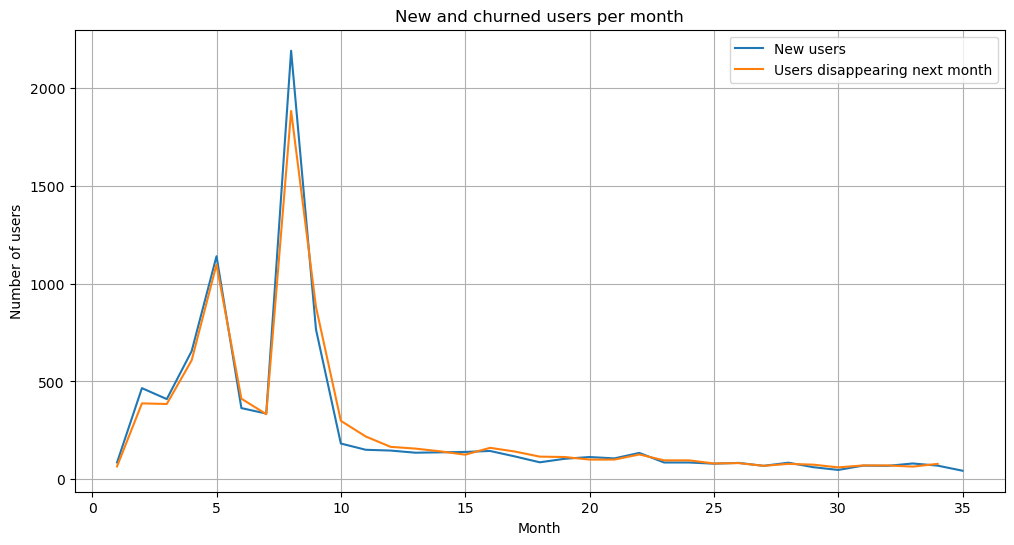

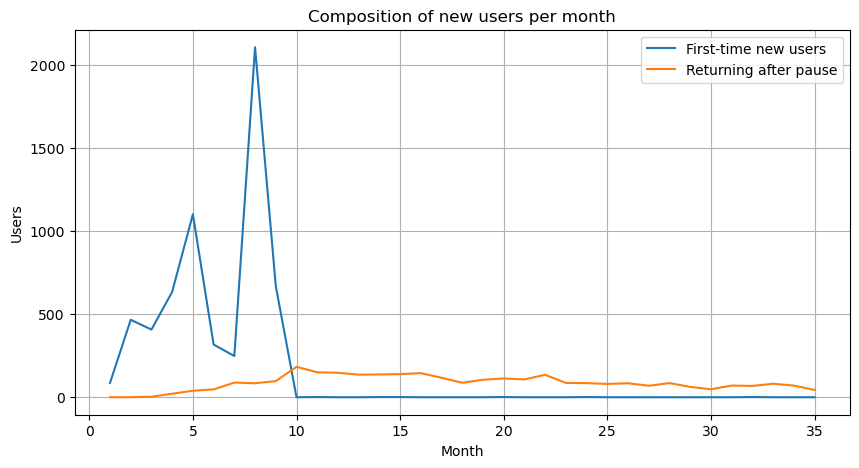

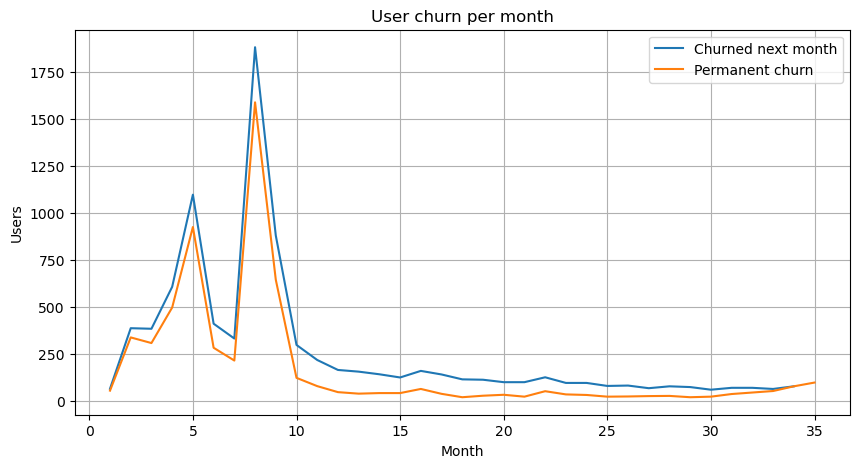

In [71]:
# New vs churned users
plt.figure(figsize=(12,6))
plt.plot(user_flow['month_idx'], user_flow['new_users'], label="New users")
plt.plot(user_flow['month_idx'], user_flow['churned_next_month'], label="Users disappearing next month")
plt.xlabel("Month")
plt.ylabel("Number of users")
plt.title("New and churned users per month")
plt.legend()
plt.grid(True)
plt.savefig(f'users_over_time.png')
plt.show()

# First time users vs users coming back after a pause
plt.figure(figsize=(10,5))
plt.plot(user_flow['month_idx'], user_flow['first_time_new'], label="First-time new users")
plt.plot(user_flow['month_idx'], user_flow['returning_after_pause'], label="Returning after pause")
plt.title("Composition of new users per month")
plt.xlabel("Month")
plt.ylabel("Users")
plt.legend()
plt.grid(True)
plt.show()

# Permanent vs temporary churned users
plt.figure(figsize=(10,5))
plt.plot(user_flow['month_idx'], user_flow['churned_next_month'], label="Churned next month")
plt.plot(user_flow['month_idx'], user_flow['permanent_churn'], label="Permanent churn")
plt.title("User churn per month")
plt.xlabel("Month")
plt.ylabel("Users")
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Number of ratings per user per month
user_month_counts = (
    ratings.groupby(['month_idx', 'userId'])
           .size()
           .reset_index(name='n_ratings')
)

# Average per month
avg_per_month = (
    user_month_counts.groupby('month_idx')['n_ratings']
                     .mean()
                     .reset_index(name='avg_ratings_per_user')
)

display(avg_per_month)

month_idx  avg_ratings_per_user
0           1            132.511628
1           2            138.759259
2           3            107.255906
3           4            116.110540
4           5            139.014504
5           6             91.008681
6           7             84.588000
7           8            123.374204
8           9             91.448026
9          10             33.156538
10         11             20.597468
11         12             18.832817
12         13             17.648464
13         14             18.025547
14         15             18.380074
15         16             16.431034
16         17             18.105691
17         18             16.109948
18         19             12.177778
19         20             15.333333
20         21             18.795699
21         22             14.618182
22         23             13.944134
23         24             14.607143
24         25             18.807947
25         26             12.350649
26         27             11.735714
27         28             12.211538
28         29             15.187050
29         30             11.544643
30         31              8.380165
31         32             16.033613
32         33              9.798450
33         34             13.820896
34         35             15.111111

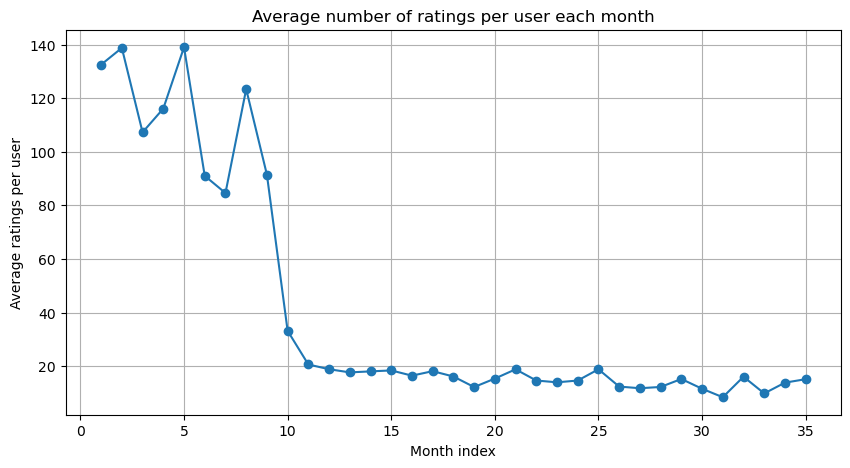

In [73]:
plt.figure(figsize=(10,5))
plt.plot(avg_per_month['month_idx'], avg_per_month['avg_ratings_per_user'], marker='o')
plt.xlabel("Month index")
plt.ylabel("Average ratings per user")
plt.title("Average number of ratings per user each month")
plt.grid(True)
plt.show()

In [74]:
# Number of items with active, new and churned ratings

movies_per_month = {m: set(df.loc[df['ym'] == m, 'movieId'].unique()) for m in months}
movie_counts_month = (df
                      .groupby(['ym','movieId'])
                      .size()
                      .rename('n_ratings')
                      .reset_index())


rows = []
for i, m in enumerate(months):
    items_now = movies_per_month[m]
    items_prev = movies_per_month[months[i-1]] if i > 0 else set()
    items_next = movies_per_month[months[i+1]] if i < len(months)-1 else set()

    active = len(items_now)
    new_items = len(items_now - items_prev)                      
    returning_items = len(items_now & items_prev)                 
    churned_next = len(items_now - items_next) if i < len(months)-1 else np.nan  

    churn_rate = (churned_next / active) if (active > 0 and pd.notna(churned_next)) else np.nan
    retention = (1 - churn_rate) if pd.notna(churn_rate) else np.nan

    monthly_total_ratings = int(df.loc[df['ym']==m].shape[0])

    rows.append({
        'month': str(m),
        'active_movies': active,
        'new_movies': new_items,
        'returning_movies': returning_items,
        'churned_next_month_movies': churned_next,
        'retention_rate_next_month_movies': round(retention, 4) if pd.notna(retention) else np.nan,
        'total_ratings_this_month': monthly_total_ratings,
        'net_title_change_vs_next': (len(items_next) - active) if i < len(months)-1 else np.nan
    })

item_flow = pd.DataFrame(rows)
item_flow['month_idx'] = range(1, len(item_flow)+1)
display(item_flow)
# item_flow.to_csv("item_flow_by_month.csv", index=False)


month  active_movies  new_movies  returning_movies  \
0   2000-04           2152        2152                 0   
1   2000-05           2920         807              2113   
2   2000-06           2913         209              2704   
3   2000-07           3135         323              2812   
4   2000-08           3298         250              3048   
5   2000-09           3083         111              2972   
6   2000-10           2993         189              2804   
7   2000-11           3552         570              2982   
8   2000-12           3334          38              3296   
9   2001-01           2723          47              2676   
10  2001-02           2173         175              1998   
11  2001-03           2018         388              1630   
12  2001-04           1945         436              1509   
13  2001-05           1909         454              1455   
14  2001-06           1817         463              1354   
15  2001-07           1819         502              1317   
16  2001-08           1688         440              1248   
17  2001-09           1560         451              1109   
18  2001-10           1222         420               802   
19  2001-11           1372         628               744   
20  2001-12           1634         672               962   
21  2002-01           1537         502              1035   
22  2002-02           1351         464               887   
23  2002-03           1412         591               821   
24  2002-04           1580         671               909   
25  2002-05           1188         382               806   
26  2002-06           1036         458               578   
27  2002-07           1198         598               600   
28  2002-08           1223         534               689   
29  2002-09            951         416               535   
30  2002-10            729         356               373   
31  2002-11           1187         726               461   
32  2002-12            833         331               502   
33  2003-01           1171         685               486   
34  2003-02            984         430               554   

    churned_next_month_movies  retention_rate_next_month_movies  \
0                        39.0                            0.9819   
1                       216.0                            0.9260   
2                       101.0                            0.9653   
3                        87.0                            0.9722   
4                       326.0                            0.9012   
5                       279.0                            0.9095   
6                        11.0                            0.9963   
7                       256.0                            0.9279   
8                       658.0                            0.8026   
9                       725.0                            0.7337   
10                      543.0                            0.7501   
11                      509.0                            0.7478   
12                      490.0                            0.7481   
13                      555.0                            0.7093   
14                      500.0                            0.7248   
15                      571.0                            0.6861   
16                      579.0                            0.6570   
17                      758.0                            0.5141   
18                      478.0                            0.6088   
19                      410.0                            0.7012   
20                      599.0                            0.6334   
21                      650.0                            0.5771   
22                      530.0                            0.6077   
23                      503.0                            0.6438   
24                      774.0                            0.5101   
25                      610.0                            0.4865   
26                      436.0       

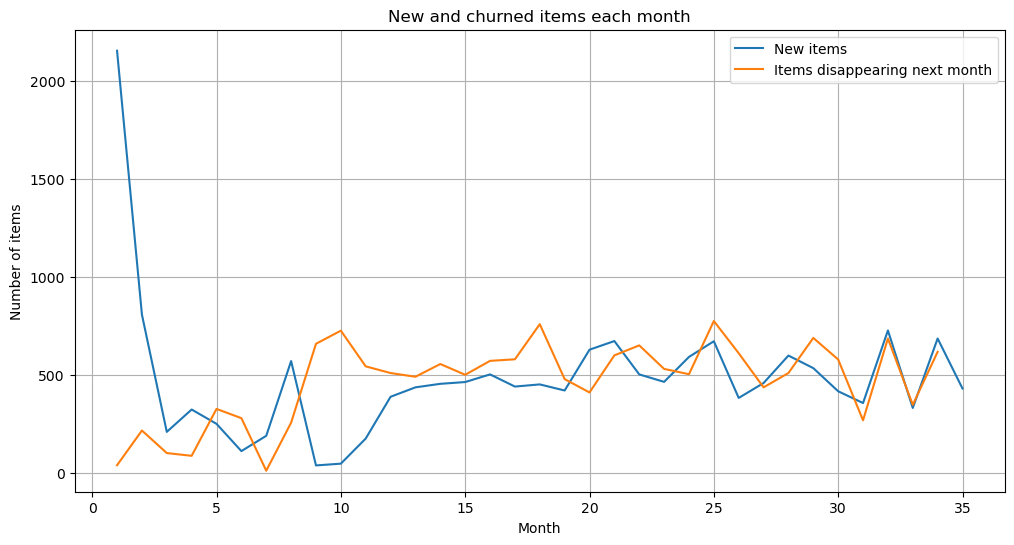

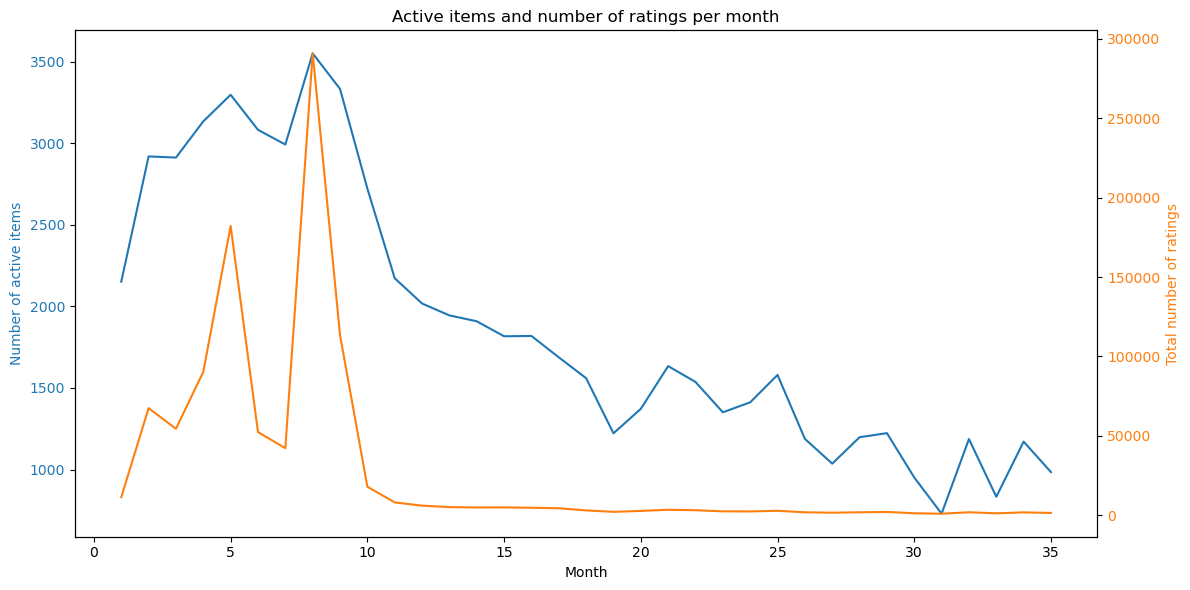

In [75]:
# New vs churned items each month
plt.figure(figsize=(12,6))
plt.plot(item_flow['month_idx'], item_flow['new_movies'], label="New items")
plt.plot(item_flow['month_idx'], item_flow['churned_next_month_movies'], label="Items disappearing next month")
plt.xlabel("Month")
plt.ylabel("Number of items")
plt.title("New and churned items each month")
plt.legend()
plt.grid(True)
plt.show()

# Active items and the total number of ratings each month
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of active items", color=color)
ax1.plot(item_flow['month_idx'], item_flow['active_movies'], color=color, label="Active items")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel("Total number of ratings", color=color)
ax2.plot(item_flow['month_idx'], item_flow['total_ratings_this_month'], color=color, label="Total number of ratings")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Active items and number of ratings per month")
fig.tight_layout()
plt.show()


In [83]:
"""
# --- 4) Per-film livsløp: første/siste måned, ant. aktive måneder, total ratings, lengste pause ---
# Første og siste måned med rating pr film
first_last = (df.groupby('movieId')['ym']
                .agg(first='min', last='max')
                .reset_index())

# Antall måneder en film er "aktiv" (har >=1 rating den måneden)
active_months = (df.groupby(['movieId','ym'])
                   .size()
                   .reset_index()
                   .groupby('movieId')['ym']
                   .nunique()
                   .rename('months_active')
                   .reset_index())

# Totalt antall ratings pr film
total_ratings_per_movie = (df.groupby('movieId')
                             .size()
                             .rename('total_ratings')
                             .reset_index())

# Lengste sammenhengende "tørke" (antall mellomliggende måneder uten rating)
# Vi regner gap i indekserte måneder for hver film
month_index_map = {m: idx for idx, m in enumerate(months)}  # 0-basert posisjon i tidsaksen

def longest_gap(sub):
    idxs = sorted(month_index_map[p] for p in sub['ym'].unique())
    if len(idxs) <= 1:
        return 0
    gaps = [idxs[i+1] - idxs[i] - 1 for i in range(len(idxs)-1)]
    return max(gaps)

gap_df = (df[['movieId','ym']].drop_duplicates()
            .groupby('movieId')
            .apply(longest_gap)
            .rename('longest_gap_months')
            .reset_index())

movie_life = (first_last
              .merge(active_months, on='movieId', how='left')
              .merge(total_ratings_per_movie, on='movieId', how='left')
              .merge(gap_df, on='movieId', how='left'))

# Legg til “lifespan” i måneder (fra første til siste måned, inkl.)
def span_in_months(row):
    return (row['last'].year - row['first'].year)*12 + (row['last'].month - row['first'].month) + 1
movie_life['lifespan_months'] = movie_life.apply(span_in_months, axis=1)

# Indikator: får filmen nye ratings etter første måned? (dvs aktiv > 1 mnd)
movie_life['has_new_ratings_later'] = movie_life['months_active'] > 1

display(movie_life)

# movie_life.to_csv("movie_lifecycle_summary.csv", index=False)

# --- 5) Eksempler/uttrekk: filmer som får nye ratings underveis ---
# a) Filmer som er aktive i mange måneder (seiglivet)
long_lived = (movie_life
              .sort_values(['months_active','total_ratings'], ascending=[False, False])
              .head(20))

# b) Filmer med store pauser, men som "kommer tilbake"
come_back = (movie_life[movie_life['longest_gap_months'] >= 3]
             .sort_values(['longest_gap_months','months_active','total_ratings'], ascending=[False, False, False])
             .head(20))

print("Top 20 'seiglivete' filmer (mange aktive måneder):")
display(long_lived[['movieId','first','last','months_active','lifespan_months','total_ratings','longest_gap_months']])

print("Top 20 'comeback'-filmer (lange pauser, så nye ratings senere):")
display(come_back[['movieId','first','last','months_active','lifespan_months','total_ratings','longest_gap_months']])
"""

'\n# --- 4) Per-film livsløp: første/siste måned, ant. aktive måneder, total ratings, lengste pause ---\n# Første og siste måned med rating pr film\nfirst_last = (df.groupby(\'movieId\')[\'ym\']\n                .agg(first=\'min\', last=\'max\')\n                .reset_index())\n\n# Antall måneder en film er "aktiv" (har >=1 rating den måneden)\nactive_months = (df.groupby([\'movieId\',\'ym\'])\n                   .size()\n                   .reset_index()\n                   .groupby(\'movieId\')[\'ym\']\n                   .nunique()\n                   .rename(\'months_active\')\n                   .reset_index())\n\n# Totalt antall ratings pr film\ntotal_ratings_per_movie = (df.groupby(\'movieId\')\n                             .size()\n                             .rename(\'total_ratings\')\n                             .reset_index())\n\n# Lengste sammenhengende "tørke" (antall mellomliggende måneder uten rating)\n# Vi regner gap i indekserte måneder for hver film\nmonth_index_ma

In [84]:
"""
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='Gini index')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()


#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='ARP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='APLT')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='RMSE')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='RMSE CP')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='Precision@10')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Precision CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='Precision@10 CP')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='Recall@10')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='Recall@10 CP')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()
"""

"\n#Gini\nplt.figure(figsize=(7.5, 4.5))\nplt.plot(months, gini_values, marker='o', color='b', label='Gini index')\nplt.title('Gini index Over Time ↓')\nplt.xlabel('month')\nplt.ylabel('Gini')\nplt.grid(True)\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(7.5, 4.5))\nplt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')\nplt.title('Gini index Over Time ↓')\nplt.xlabel('month')\nplt.ylabel('Gini')\nplt.grid(True)\nplt.legend()\nplt.show()\n\n\n#arp\nplt.figure(figsize=(7.5, 4.5))\nplt.plot(months, arp, marker='o', color='b', label='ARP')\nplt.title('ARP Over Time ↓')\nplt.xlabel('month')\nplt.ylabel('ARP')\nplt.grid(True)\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(7.5, 4.5))\nplt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')\nplt.title('ARP Over Time ↓')\nplt.xlabel('month')\nplt.ylabel('ARP')\nplt.grid(True)\nplt.legend()\nplt.show()\n\n#Aplt\nplt.figure(figsize=(7.5, 4.5))\nplt.plot

In [138]:
df_user_ratings = ratings.copy()
if not pd.api.types.is_datetime64_any_dtype(df_user_ratings['timestamp']):
    df_user_ratings['timestamp'] = pd.to_datetime(df['timestamp'])

df_user_ratings = df_user_ratings.sort_values('timestamp')
df_user_ratings['ym'] = df_user_ratings['timestamp'].dt.to_period('M')
months = np.array(sorted(df_user_ratings['ym'].unique(), key=lambda x: (x.year, x.month)))
df_user_ratings

userId  movieId  rating           timestamp       ym  month_idx
1000138    6040      858       4 2000-04-25 23:05:32  2000-04          1
1000153    6040     2384       4 2000-04-25 23:05:54  2000-04          1
999873     6040      593       5 2000-04-25 23:05:54  2000-04          1
1000007    6040     1961       4 2000-04-25 23:06:17  2000-04          1
1000192    6040     2019       5 2000-04-25 23:06:17  2000-04          1
...         ...      ...     ...                 ...      ...        ...
825793     4958     2399       1 2003-02-28 17:45:38  2003-02         35
825438     4958     1407       5 2003-02-28 17:47:23  2003-02         35
825731     4958     2634       3 2003-02-28 17:49:08  2003-02         35
825724     4958     3264       4 2003-02-28 17:49:08  2003-02         35
825603     4958     1924       4 2003-02-28 17:49:50  2003-02         35

[1000209 rows x 6 columns]

         Long Tail  Short Head   total  short_head_pct  long_tail_pct
ym                                                                   
2000-04       3913        7483   11396       65.663391      34.336609
2000-05      22135       45302   67437       67.176772      32.823228
2000-06      17690       36796   54486       67.532944      32.467056
2000-07      30618       59716   90334       66.105785      33.894215
2000-08      64746      117363  182109       64.446568      35.553432
2000-09      17936       34485   52421       65.784705      34.215295
2000-10      14635       27659   42294       65.396983      34.603017
2000-11      98130      192663  290793       66.254346      33.745654
2000-12      38939       74548  113487       65.688581      34.311419
2001-01       7207       10797   18004       59.970007      40.029993
2001-02       3355        4781    8136       58.763520      41.236480
2001-03       2501        3582    6083       58.885418      41.114582
2001-04       2316  

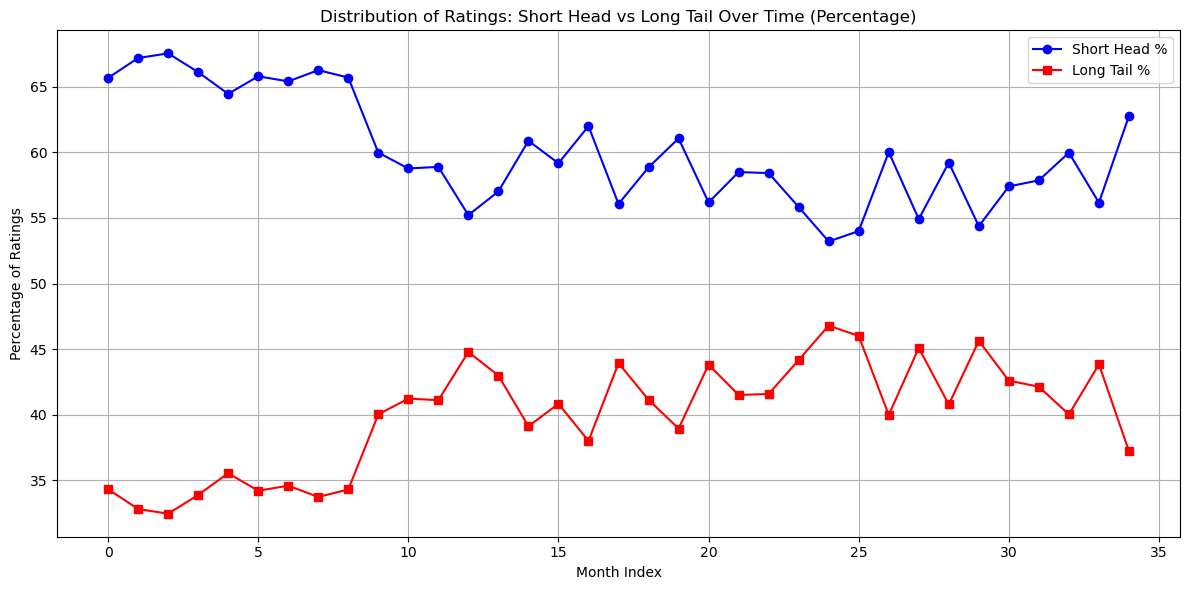

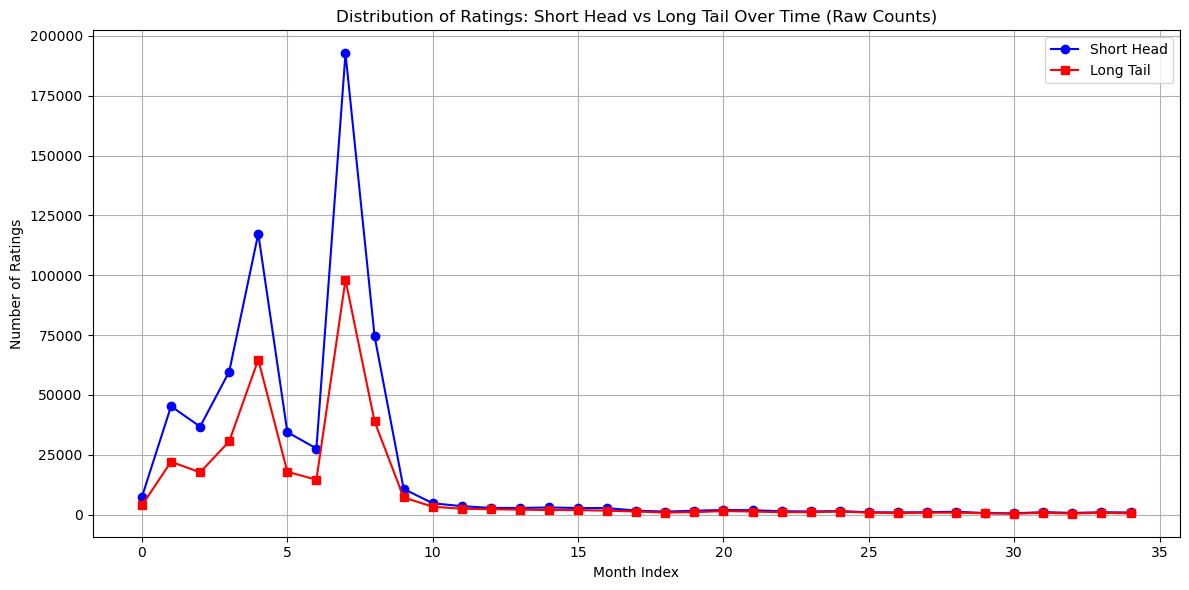

In [142]:
# Define what constitutes "short head" vs "long tail"
# Common approach: top 20% most popular items = short head, rest = long tail
# Or: items with X or more ratings = short head
# Calculate overall item popularity (total ratings per movie across all time)
item_popularity = df_user_ratings.groupby('movieId').size().sort_values(ascending=False)
# Define short head (e.g., top 20% most popular items)
n_items = len(item_popularity)
short_head_threshold = int(n_items * 0.2)  # Top 20%
short_head_items = set(item_popularity.head(short_head_threshold).index)
# Or alternatively, define by rating count threshold
# short_head_items = set(item_popularity[item_popularity >= 100].index)  # items with 100+ ratings
# Now analyze per month
df_user_ratings['is_short_head'] = df_user_ratings['movieId'].isin(short_head_items)
monthly_distribution = df_user_ratings.groupby(['ym', 'is_short_head']).size().unstack(fill_value=0)
monthly_distribution.columns = ['Long Tail', 'Short Head']
monthly_distribution['total'] = monthly_distribution.sum(axis=1)
monthly_distribution['short_head_pct'] = (monthly_distribution['Short Head'] / monthly_distribution['total']) * 100
monthly_distribution['long_tail_pct'] = (monthly_distribution['Long Tail'] / monthly_distribution['total']) * 100
print(monthly_distribution)

# Plot the trend - Percentages
plt.figure(figsize=(12, 6))
plt.plot(range(len(monthly_distribution)), monthly_distribution['short_head_pct'], 
         marker='o', label='Short Head %', color='blue')
plt.plot(range(len(monthly_distribution)), monthly_distribution['long_tail_pct'], 
         marker='s', label='Long Tail %', color='red')
plt.xlabel('Month Index')
plt.ylabel('Percentage of Ratings')
plt.title('Distribution of Ratings: Short Head vs Long Tail Over Time (Percentage)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the trend - Raw Numbers
plt.figure(figsize=(12, 6))
plt.plot(range(len(monthly_distribution)), monthly_distribution['Short Head'], 
         marker='o', label='Short Head', color='blue')
plt.plot(range(len(monthly_distribution)), monthly_distribution['Long Tail'], 
         marker='s', label='Long Tail', color='red')
plt.xlabel('Month Index')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings: Short Head vs Long Tail Over Time (Raw Counts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

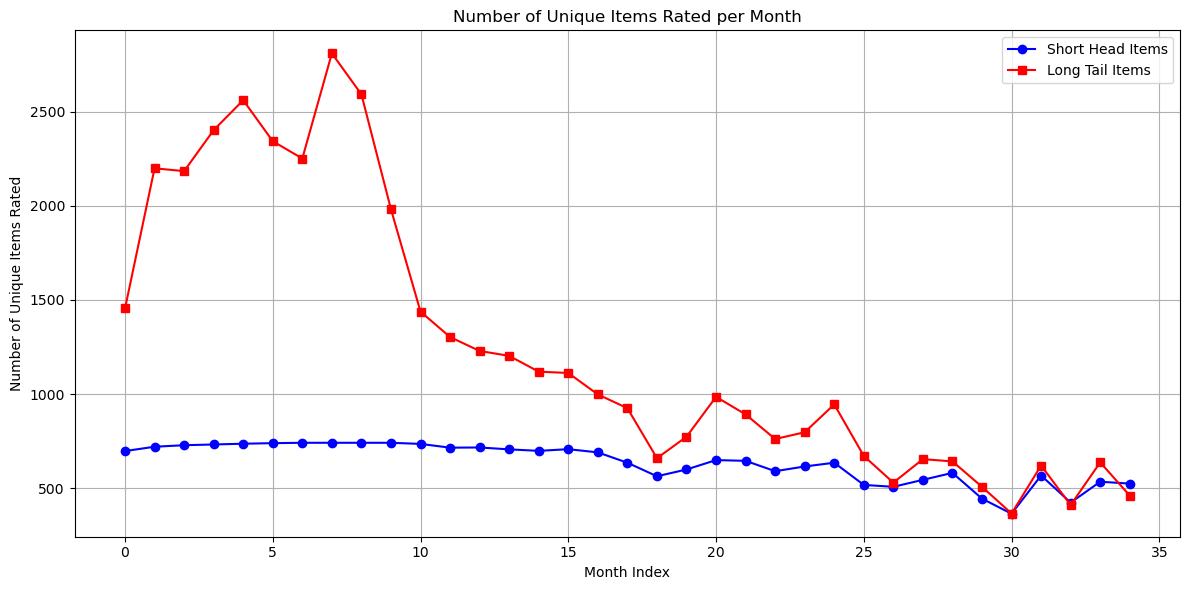

In [144]:
# Number of unique items rated per month (short head vs long tail)
unique_items_monthly = df_user_ratings.groupby(['ym', 'is_short_head'])['movieId'].nunique().unstack(fill_value=0)
unique_items_monthly.columns = ['Long Tail Items', 'Short Head Items']

plt.figure(figsize=(12, 6))
plt.plot(range(len(unique_items_monthly)), unique_items_monthly['Short Head Items'], 
         marker='o', label='Short Head Items', color='blue')
plt.plot(range(len(unique_items_monthly)), unique_items_monthly['Long Tail Items'], 
         marker='s', label='Long Tail Items', color='red')
plt.xlabel('Month Index')
plt.ylabel('Number of Unique Items Rated')
plt.title('Number of Unique Items Rated per Month')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

             mean       std   count
ym                                 
2000-04  3.553352  1.086216   11396
2000-05  3.613447  1.142933   67437
2000-06  3.633906  1.112886   54486
2000-07  3.630073  1.091738   90334
2000-08  3.572174  1.122029  182109
2000-09  3.609717  1.117345   52421
2000-10  3.620419  1.087371   42294
2000-11  3.571671  1.130624  290793
2000-12  3.585019  1.115809  113487
2001-01  3.543657  1.064980   18004
2001-02  3.551500  1.088263    8136
2001-03  3.528358  1.053631    6083
2001-04  3.471282  1.111787    5171
2001-05  3.460822  1.052025    4939
2001-06  3.472797  1.079897    4981
2001-07  3.476600  1.078435    4765
2001-08  3.467670  1.136817    4454
2001-09  3.541111  1.048258    3077
2001-10  3.415602  1.100265    2192
2001-11  3.594203  1.083252    2760
2001-12  3.496568  1.089153    3496
2002-01  3.557525  1.071235    3216
2002-02  3.473558  1.071821    2496
2002-03  3.279951  1.121751    2454
2002-04  3.488732  1.108366    2840
2002-05  3.556782  1.127199 

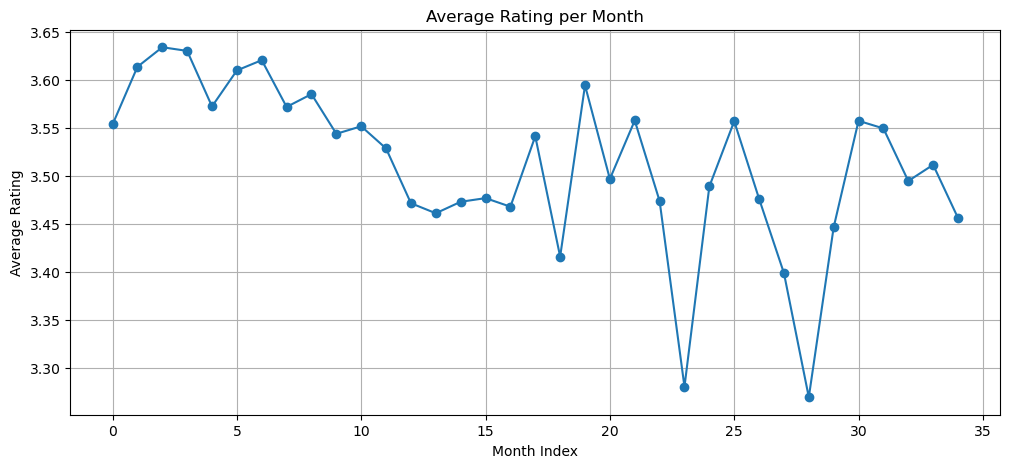

In [146]:
monthly_rating_stats = df_user_ratings.groupby('ym')['rating'].agg(['mean', 'std', 'count'])
print(monthly_rating_stats)

plt.figure(figsize=(12, 5))
plt.plot(range(len(monthly_rating_stats)), monthly_rating_stats['mean'], marker='o')
plt.xlabel('Month Index')
plt.ylabel('Average Rating')
plt.title('Average Rating per Month')
plt.grid(True)
plt.show()

In [147]:
for month, (trainset, testset, *_) in zip(months, train_test_sets):
    n_train = trainset.n_ratings
    n_test = len(testset)
    print(f"Month {month}: Train={n_train}, Test={n_test}, Ratio={n_train/n_test:.2f}")

Month 2000-04: Train=64073, Test=12115, Ratio=5.29
Month 2000-05: Train=59871, Test=13621, Ratio=4.40
Month 2000-06: Train=83503, Test=18305, Ratio=4.56
Month 2000-07: Train=180910, Test=35949, Ratio=5.03
Month 2000-08: Train=62943, Test=25802, Ratio=2.44
Month 2000-09: Train=39128, Test=22414, Ratio=1.75
Month 2000-10: Train=254731, Test=82698, Ratio=3.08
Month 2000-11: Train=146813, Test=55521, Ratio=2.64
Month 2000-12: Train=28447, Test=33801, Ratio=0.84
Month 2001-01: Train=10048, Test=22774, Ratio=0.44
Month 2001-02: Train=5758, Test=15952, Ratio=0.36
Month 2001-03: Train=4862, Test=15613, Ratio=0.31
Month 2001-04: Train=5139, Test=12676, Ratio=0.41
Month 2001-05: Train=5181, Test=13069, Ratio=0.40
Month 2001-06: Train=4224, Test=11478, Ratio=0.37
Month 2001-07: Train=5152, Test=10563, Ratio=0.49
Month 2001-08: Train=3126, Test=7278, Ratio=0.43
Month 2001-09: Train=2125, Test=4918, Ratio=0.43
Month 2001-10: Train=2961, Test=6657, Ratio=0.44
Month 2001-11: Train=2704, Test=5392, Ra

    month       ym  recall@10_mean  recall@10_std  n_users  n_ratings
0       1  2000-04        0.383474       0.000000       86      11396
1       2  2000-05        0.360846       0.026433      486      67437
2       3  2000-06        0.389979       0.009552      508      54486
3       4  2000-07        0.348837       0.006781      778      90334
4       5  2000-08        0.382879       0.006835     1310     182109
5       6  2000-09        0.369302       0.015296      576      52421
6       7  2000-10        0.349209       0.002522      500      42294
7       8  2000-11        0.366652       0.005532     2357     290793
8       9  2000-12        0.374528       0.007349     1241     113487
9      10  2001-01        0.379690       0.006657      543      18004
10     11  2001-02        0.380893       0.006343      395       8136
11     12  2001-03        0.362116       0.003272      323       6083
12     13  2001-04        0.329831       0.002162      293       5171
13     14  2001-05  

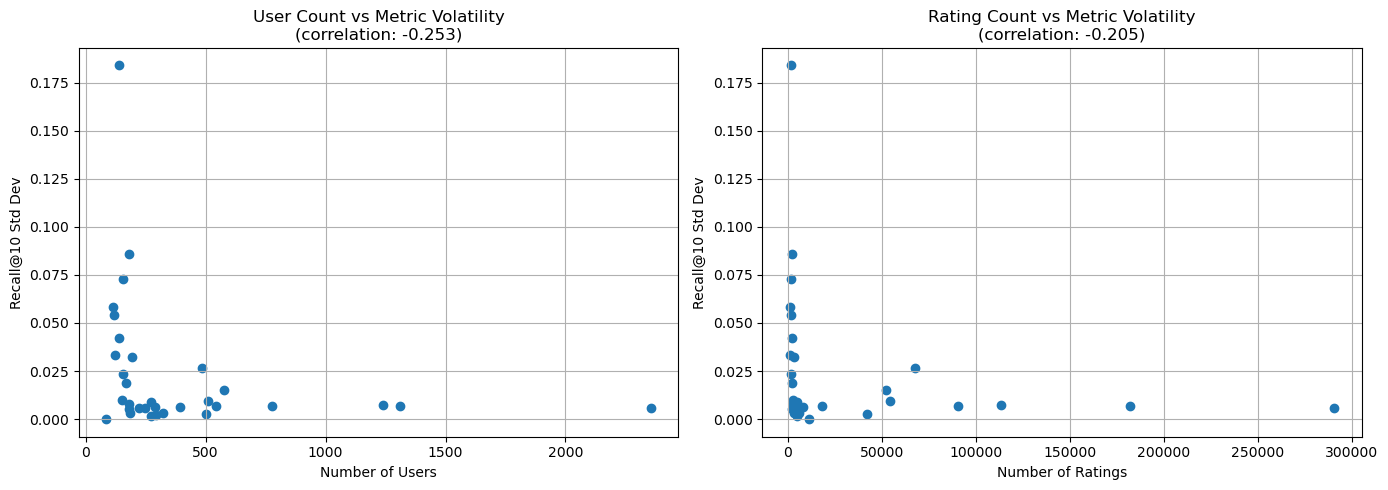

In [151]:
# Add an integer month index to monthly_stats
monthly_stats_reset = monthly_stats.reset_index()
monthly_stats_reset['month'] = range(1, len(monthly_stats_reset) + 1)

# Now merge on the integer month
diagnostic_df = agg_main.merge(monthly_stats_reset, on='month')
print(diagnostic_df[['month', 'ym', 'recall@10_mean', 'recall@10_std', 'n_users', 'n_ratings']])

# Correlation between sample size and metric stability
correlation_users = diagnostic_df['n_users'].corr(diagnostic_df['recall@10_std'])
correlation_ratings = diagnostic_df['n_ratings'].corr(diagnostic_df['recall@10_std'])

print(f"\nCorrelation between number of users and recall std: {correlation_users:.3f}")
print(f"Correlation between number of ratings and recall std: {correlation_ratings:.3f}")

# If correlation is negative, it means fewer users/ratings → more volatility
# Let's also visualize this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(diagnostic_df['n_users'], diagnostic_df['recall@10_std'])
ax1.set_xlabel('Number of Users')
ax1.set_ylabel('Recall@10 Std Dev')
ax1.set_title(f'User Count vs Metric Volatility\n(correlation: {correlation_users:.3f})')
ax1.grid(True)

ax2.scatter(diagnostic_df['n_ratings'], diagnostic_df['recall@10_std'])
ax2.set_xlabel('Number of Ratings')
ax2.set_ylabel('Recall@10 Std Dev')
ax2.set_title(f'Rating Count vs Metric Volatility\n(correlation: {correlation_ratings:.3f})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [152]:
# Filter out months with too few users
min_users = 300  # or 500
reliable_months = diagnostic_df[diagnostic_df['n_users'] >= min_users]

print(f"Keeping {len(reliable_months)} out of {len(diagnostic_df)} months")
print(f"Discarding months: {diagnostic_df[diagnostic_df['n_users'] < min_users]['ym'].tolist()}")

Keeping 11 out of 32 months
Discarding months: [Period('2000-04', 'M'), Period('2001-04', 'M'), Period('2001-05', 'M'), Period('2001-06', 'M'), Period('2001-07', 'M'), Period('2001-08', 'M'), Period('2001-09', 'M'), Period('2001-10', 'M'), Period('2001-11', 'M'), Period('2001-12', 'M'), Period('2002-01', 'M'), Period('2002-02', 'M'), Period('2002-03', 'M'), Period('2002-04', 'M'), Period('2002-05', 'M'), Period('2002-06', 'M'), Period('2002-07', 'M'), Period('2002-08', 'M'), Period('2002-09', 'M'), Period('2002-10', 'M'), Period('2002-11', 'M')]


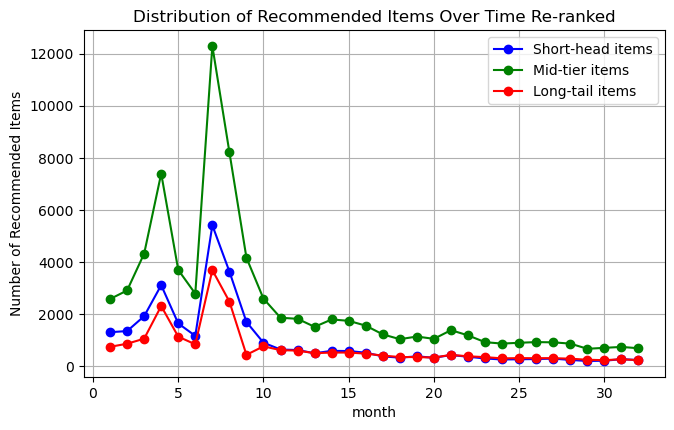

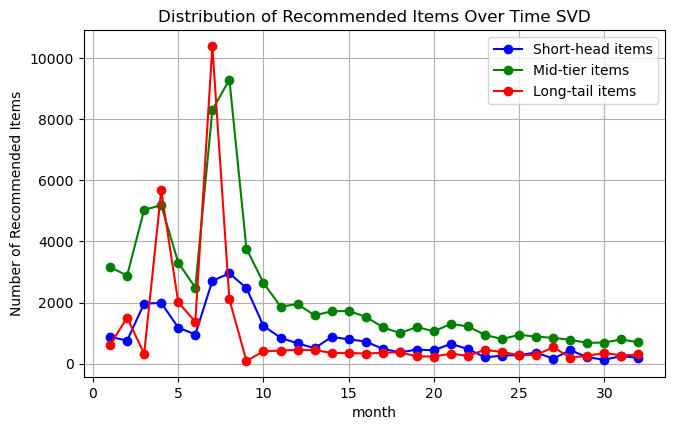

In [85]:
months = group_counts_df['month']
short_head_counts = group_counts_df['short_head_count']
mid_counts = group_counts_df['mid_count']
long_tail_counts = group_counts_df['long_tail_count']


plt.figure(figsize=(7.5, 4.5))

plt.plot(months, short_head_counts, marker='o', color='b', label='Short-head items')
plt.plot(months, mid_counts, marker='o', color='g', label='Mid-tier items')
plt.plot(months, long_tail_counts, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time Re-ranked')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()


months2 = group_counts_svd_df['month']
short_head_counts2 = group_counts_svd_df['short_head_count']
mid_counts2 = group_counts_svd_df['mid_count']
long_tail_counts2 = group_counts_svd_df['long_tail_count']

plt.figure(figsize=(7.5, 4.5))

plt.plot(months2, short_head_counts2, marker='o', color='b', label='Short-head items')
plt.plot(months2, mid_counts2, marker='o', color='g', label='Mid-tier items')
plt.plot(months2, long_tail_counts2, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time SVD')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()

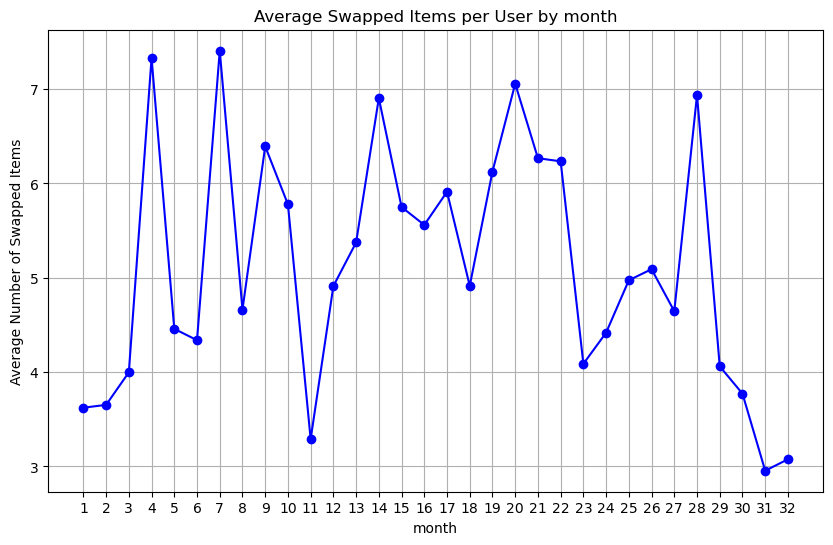

In [86]:
months = sorted(monthly_swapped_counts.keys())
avg_swaps = [monthly_swapped_counts[w] for w in months]

plt.figure(figsize=(10,6))
plt.plot(months, avg_swaps, marker='o', linestyle='-', color='b')
plt.title("Average Swapped Items per User by month")
plt.xlabel("month")
plt.ylabel("Average Number of Swapped Items")
plt.grid(True)
plt.xticks(months)
plt.show()


In [87]:
# Ensure the timestamp column is a datetime type
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Convert timestamps to monthly periods
monthly_periods = ratings['timestamp'].dt.to_period('M')

# Count the unique months
num_months = monthly_periods.nunique()
print("Number of months in the dataset:", num_months)

Number of months in the dataset: 35


In [88]:
precision_values = [result['precision@10'] for result in monthly_results]

cp_mean_precision = np.mean(results_df['precision@10'])
svd_mean_precision =np.mean(precision_values)

print(f"Mean precision for CP: {cp_mean_precision:.4f}")
print(f"Mean precision for SVD: {svd_mean_precision:.4f}")

Mean precision for CP: 0.7371
Mean precision for SVD: 0.6138


In [89]:
recall_values = [result['recall@10'] for result in monthly_results]

cp_mean_recall = np.mean(results_df['recall@10'])
svd_mean_recall =np.mean(recall_values)

print(f"Mean recall for CP: {cp_mean_recall:.4f}")
print(f"Mean recall for SVD: {svd_mean_recall:.4f}")

Mean recall for CP: 0.7861
Mean recall for SVD: 0.3867


In [90]:
rmse_values = [result['rmse'] for result in monthly_results]

cp_mean_rmse = np.mean(results_df['rmse'])
svd_mean_rmse =np.mean(rmse_values)

print(f"Mean rmse for CP: {cp_mean_rmse:.4f}")
print(f"Mean rmse for SVD: {svd_mean_rmse:.4f}")

Mean rmse for CP: 0.8849
Mean rmse for SVD: 0.9935


In [91]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Metric':       ['RMSE ↓',       'Precision@10 ↑',       'Recall@10 ↑'],
    'SVD':          [svd_mean_rmse, svd_mean_precision,  svd_mean_recall],
    'CP': [cp_mean_rmse, cp_mean_precision, cp_mean_recall]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Metric         |   SVD |    CP |
|----------------|-------|-------|
| RMSE ↓         | 0.993 | 0.885 |
| Precision@10 ↑ | 0.614 | 0.737 |
| Recall@10 ↑    | 0.387 | 0.786 |


In [92]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.7025
Mean Gini Index for SVD: 0.7241


In [93]:
arp_values = [result['arp'] for result in monthly_results]

cp_mean_arp = np.mean(results_df['arp'])
svd_mean_arp =np.mean(arp_values)

print(f"Mean arp for CP: {cp_mean_arp:.4f}")
print(f"Mean arp for SVD: {svd_mean_arp:.4f}")

Mean arp for CP: 0.1698
Mean arp for SVD: 0.3413


In [94]:
aplt_values = [result['aplt'] for result in monthly_results]

cp_mean_aplt = np.mean(results_df['aplt'])
svd_mean_aplt =np.mean(aplt_values)

print(f"Mean aplt for CP: {cp_mean_aplt:.4f}")
print(f"Mean aplt for SVD: {svd_mean_aplt:.4f}")

Mean aplt for CP: 0.1802
Mean aplt for SVD: 0.1174


In [95]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Beyond Metric':       ['Gini-Index ↓',       'ARP ↓',       'APLT ↑'],
    'SVD':          [svd_mean_gini, svd_mean_arp,  svd_mean_aplt],
    'CP': [cp_mean_gini, cp_mean_arp, cp_mean_aplt]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Beyond Metric   |   SVD |    CP |
|-----------------|-------|-------|
| Gini-Index ↓    | 0.724 | 0.703 |
| ARP ↓           | 0.341 | 0.170 |
| APLT ↑          | 0.117 | 0.180 |


In [96]:
top10_df = (
    recommendations_df
    # 1) Sort by month, then user, then rating descending 
    .sort_values(['month','userId','rating'], ascending=[True,True,False])
    # 2) For each (month, userId) pair, keep only the first 10 rows
    .groupby(['month','userId'], group_keys=False)
    .head(10)
    .reset_index(drop=True)
)
top10_df.head(15)

userId  movieId    rating  month
0     5574      858  5.000000      1
1     5574     1221  4.885696      1
2     5574     2019  4.880351      1
3     5574      318  4.861907      1
4     5574     1199  4.860772      1
5     5574     1207  4.828532      1
6     5574     1204  4.815786      1
7     5574      111  4.790859      1
8     5574      608  4.779931      1
9     5574      904  4.772772      1
10    5575     1197  4.455535      1
11    5575      318  4.444508      1
12    5575     1196  4.357920      1
13    5575     2571  4.324980      1
14    5575      904  4.290417      1

In [97]:
total_movies = set(ratings['movieId'].unique())

recommended_movies = set(top10_df['movieId'].unique())
recommended_movies2 = set(reranked_df['movieId'].unique())

coverage = len(recommended_movies) / len(total_movies)
coverage2 = len(recommended_movies2) / len(total_movies)
print(f"Coverage SVD: {coverage:.2%}\t" 
     f"Coverage CP: {coverage2:.2%}") 

Coverage SVD: 50.54%	Coverage CP: 55.91%


In [98]:
coverages = []

for month in sorted(top10_df['month'].unique()):
    dfm = top10_df[top10_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


Month 1 catalog coverage: 6.66%
Month 2 catalog coverage: 12.33%
Month 3 catalog coverage: 2.35%
Month 4 catalog coverage: 8.61%
Month 5 catalog coverage: 11.66%
Month 6 catalog coverage: 10.31%
Month 7 catalog coverage: 10.23%
Month 8 catalog coverage: 9.01%
Month 9 catalog coverage: 3.62%
Month 10 catalog coverage: 5.32%
Month 11 catalog coverage: 3.37%
Month 12 catalog coverage: 6.53%
Month 13 catalog coverage: 3.64%
Month 14 catalog coverage: 4.51%
Month 15 catalog coverage: 4.13%
Month 16 catalog coverage: 5.88%
Month 17 catalog coverage: 4.02%
Month 18 catalog coverage: 7.29%
Month 19 catalog coverage: 3.86%
Month 20 catalog coverage: 1.75%
Month 21 catalog coverage: 4.83%
Month 22 catalog coverage: 3.67%
Month 23 catalog coverage: 12.52%
Month 24 catalog coverage: 5.21%
Month 25 catalog coverage: 3.32%
Month 26 catalog coverage: 2.35%
Month 27 catalog coverage: 11.04%
Month 28 catalog coverage: 3.53%
Month 29 catalog coverage: 5.56%
Month 30 catalog coverage: 12.71%
Month 31 cat

In [99]:
coverages = []

for month in sorted(reranked_df['month'].unique()):
    dfm = reranked_df[reranked_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


Month 1 catalog coverage: 7.47%
Month 2 catalog coverage: 12.47%
Month 3 catalog coverage: 2.59%
Month 4 catalog coverage: 8.88%
Month 5 catalog coverage: 11.90%
Month 6 catalog coverage: 10.47%
Month 7 catalog coverage: 10.87%
Month 8 catalog coverage: 10.25%
Month 9 catalog coverage: 4.88%
Month 10 catalog coverage: 7.04%
Month 11 catalog coverage: 4.21%
Month 12 catalog coverage: 8.26%
Month 13 catalog coverage: 5.02%
Month 14 catalog coverage: 5.21%
Month 15 catalog coverage: 5.72%
Month 16 catalog coverage: 8.01%
Month 17 catalog coverage: 5.77%
Month 18 catalog coverage: 8.26%
Month 19 catalog coverage: 5.23%
Month 20 catalog coverage: 3.48%
Month 21 catalog coverage: 6.50%
Month 22 catalog coverage: 4.64%
Month 23 catalog coverage: 12.09%
Month 24 catalog coverage: 5.53%
Month 25 catalog coverage: 4.45%
Month 26 catalog coverage: 3.40%
Month 27 catalog coverage: 11.49%
Month 28 catalog coverage: 5.61%
Month 29 catalog coverage: 6.23%
Month 30 catalog coverage: 12.68%
Month 31 ca

In [100]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    top10_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 SVD: {coverage_at_10:.2%}")



Test‐coverage@10 SVD: 9.21%


In [101]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    reranked_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 CP: {coverage_at_10:.2%}")


Test‐coverage@10 CP: 8.35%


In [102]:
# 1) Build a list of all months in your recommendations
months = sorted(top10_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = top10_df[top10_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for SVD: {avg_cov:.2f}%")
else:
    print("No months to process.")


Month 1 test‐coverage@10: 3.56%
Month 2 test‐coverage@10: 3.18%
Month 3 test‐coverage@10: 4.07%
Month 4 test‐coverage@10: 1.85%
Month 5 test‐coverage@10: 3.91%
Month 6 test‐coverage@10: 4.42%
Month 7 test‐coverage@10: 2.48%
Month 8 test‐coverage@10: 4.23%
Month 9 test‐coverage@10: 6.49%
Month 10 test‐coverage@10: 6.29%
Month 11 test‐coverage@10: 7.46%
Month 12 test‐coverage@10: 5.47%
Month 13 test‐coverage@10: 7.17%
Month 14 test‐coverage@10: 6.46%
Month 15 test‐coverage@10: 4.65%
Month 16 test‐coverage@10: 5.68%
Month 17 test‐coverage@10: 5.49%
Month 18 test‐coverage@10: 3.37%
Month 19 test‐coverage@10: 4.05%
Month 20 test‐coverage@10: 5.11%
Month 21 test‐coverage@10: 2.81%
Month 22 test‐coverage@10: 3.11%
Month 23 test‐coverage@10: 1.81%
Month 24 test‐coverage@10: 2.33%
Month 25 test‐coverage@10: 3.31%
Month 26 test‐coverage@10: 2.34%
Month 27 test‐coverage@10: 0.97%
Month 28 test‐coverage@10: 1.82%
Month 29 test‐coverage@10: 0.43%
Month 30 test‐coverage@10: 0.76%
Month 31 test‐cover

In [103]:
# 1) Build a list of all months in your recommendations
months = sorted(reranked_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = reranked_df[reranked_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for CP: {avg_cov:.2f}%")
else:
    print("No months to process.")


Month 1 test‐coverage@10: 3.00%
Month 2 test‐coverage@10: 3.22%
Month 3 test‐coverage@10: 3.37%
Month 4 test‐coverage@10: 2.69%
Month 5 test‐coverage@10: 3.97%
Month 6 test‐coverage@10: 4.02%
Month 7 test‐coverage@10: 4.26%
Month 8 test‐coverage@10: 3.43%
Month 9 test‐coverage@10: 5.51%
Month 10 test‐coverage@10: 5.55%
Month 11 test‐coverage@10: 6.54%
Month 12 test‐coverage@10: 5.15%
Month 13 test‐coverage@10: 6.50%
Month 14 test‐coverage@10: 5.78%
Month 15 test‐coverage@10: 3.78%
Month 16 test‐coverage@10: 4.75%
Month 17 test‐coverage@10: 4.90%
Month 18 test‐coverage@10: 3.14%
Month 19 test‐coverage@10: 3.74%
Month 20 test‐coverage@10: 3.85%
Month 21 test‐coverage@10: 2.81%
Month 22 test‐coverage@10: 3.16%
Month 23 test‐coverage@10: 2.06%
Month 24 test‐coverage@10: 2.53%
Month 25 test‐coverage@10: 2.58%
Month 26 test‐coverage@10: 2.08%
Month 27 test‐coverage@10: 0.90%
Month 28 test‐coverage@10: 1.89%
Month 29 test‐coverage@10: 0.43%
Month 30 test‐coverage@10: 1.10%
Month 31 test‐cover

In [104]:
# === OVERALL USER OVERLAP ===

# Collect all raw user‐IDs seen in any train split
train_users = set()
for trainset, _, *_ in train_test_sets:
    train_users |= { trainset.to_raw_uid(uid) for uid in trainset.all_users() }

# Collect all user‐IDs seen in any test split
test_users = set()
for _, testset, *_ in train_test_sets:
    test_users |= { u for u, _, _ in testset }

overlap = train_users & test_users

print(f"Overall train users: {len(train_users)}")
print(f"Overall test  users: {len(test_users)}")
print(f"Overlap users     : {len(overlap)} "
      f"({len(overlap)/len(test_users)*100:.2f}% of test users)")

# === PER-MONTH USER OVERLAP ===

# If you want to see it month by month:
months = sorted(top10_df['month'].unique())
for month, (trainset, testset, *_ ) in zip(months, train_test_sets):
    train_u = { trainset.to_raw_uid(uid) for uid in trainset.all_users() }
    test_u  = { u for u, _, _ in testset }
    ov      = train_u & test_u
    pct     = len(ov) / len(test_u) * 100 if test_u else 0.0
    print(f"Month {month}: {len(ov)} overlapping users "
          f"({pct:.2f}% of that month’s test users)")


Overall train users: 6040
Overall test  users: 1682
Overlap users     : 1682 (100.00% of test users)
Month 1: 135 overlapping users (100.00% of that month’s test users)
Month 2: 186 overlapping users (100.00% of that month’s test users)
Month 3: 251 overlapping users (100.00% of that month’s test users)
Month 4: 372 overlapping users (100.00% of that month’s test users)
Month 5: 320 overlapping users (100.00% of that month’s test users)
Month 6: 273 overlapping users (100.00% of that month’s test users)
Month 7: 740 overlapping users (100.00% of that month’s test users)
Month 8: 629 overlapping users (100.00% of that month’s test users)
Month 9: 443 overlapping users (100.00% of that month’s test users)
Month 10: 342 overlapping users (100.00% of that month’s test users)
Month 11: 268 overlapping users (100.00% of that month’s test users)
Month 12: 265 overlapping users (100.00% of that month’s test users)
Month 13: 214 overlapping users (100.00% of that month’s test users)
Month 14: 2

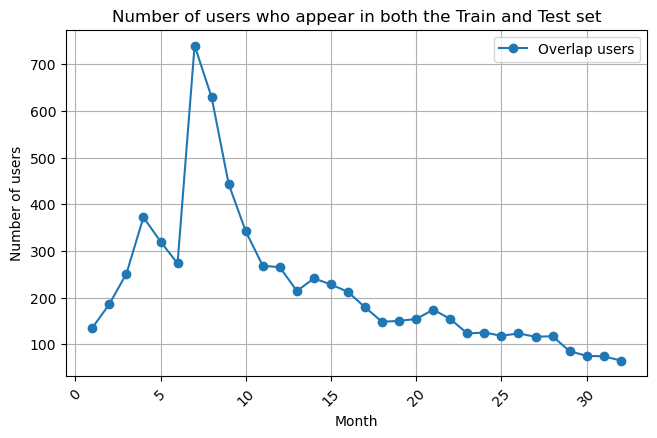

In [105]:
# 1) Gather per-month counts
months       = sorted(top10_df['month'].unique())
train_counts = []
test_counts  = []
overlap_counts = []

for month, (trainset, testset, *_) in zip(months, train_test_sets):
    # users seen in training (Surprise trainset)
    train_users = {trainset.to_raw_uid(uid) for uid in trainset.all_users()}
    # users in that month's test
    test_users  = {u for u, _, _ in testset}
    overlap     = train_users & test_users

    train_counts.append(len(train_users))
    test_counts.append(len(test_users))
    overlap_counts.append(len(overlap))

# 2) Plot all three series on one chart
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, overlap_counts, marker='o', label='Overlap users')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of users')
plt.title('Number of users who appear in both the Train and Test set')
plt.legend()
plt.grid(True)
plt.show()